So the motivation for this was, to be entirely honest, kind of selfish. I'm buying a house and I want to see how much my house *could* increase by in 'N' years. Basically, a kind of experiment. It is also handy for me to practice time-series analysis, bit of data science stuff, and some ML practice.

The project is broken down into a few parts:
1. the web-scraping, to gather data from the [RightMove.co.uk](https://www.rightmove.co.uk) website. For historical data, and then use this to try and predict how the houses will increase.
2. the analysis of the data, see if there any trends I can see from this analysis as is.
3. the forecasting, can I do some basic forecasting with the data alone, or can I set up an ML model to predict it for me.

# 1. Importing and Pre-Processing
## 1.1 Imports and Load Data

In [43]:

random_code = 42  # Random code to use and replicate results for each run.
train_frac = 0.8
year_max = 2050

# File imports 
import os

# Data Imports
# - Dataframe 
import numpy as np
import pandas as pd
# - Visualisations
import matplotlib.pyplot as plt
import seaborn as sns
# - Machine Learning
# - - Classical 
from sklearn.tree import plot_tree
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from xgboost import XGBRegressor
from hyperopt import fmin, tpe, hp
# - - Neural Networks
import torch
import torch.nn as nn
import torch.optim as optim
# - Stats
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import scipy.stats as stats 
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# - Oversampling
import smogn

# Geography imports
import plotly.express as px
        
# Personal Import
from Dataset_Snapshot import RightMoveScraper

Run the next function as needed if you need a new CSV to work with. This will generate a CSV for every run of this code, this is not ideal. Plus also as a basic tool, a separate python file will suffice.

In [3]:
"""# Create an instance of the scraper
scraper = RightMoveScraper(num_pages=10)  # Adjust the number of pages as needed
scraper.run()"""

'# Create an instance of the scraper\nscraper = RightMoveScraper(num_pages=10)  # Adjust the number of pages as needed\nscraper.run()'

In [4]:
data_file = 'rightmove_housing_data_20250330_233719.csv'
df = pd.read_csv(data_file)

## 1.2 Data Clean Up
Tidy up the data now as it's not really in a state to use just yet.

In [5]:
print(df.dtypes)  # Look at the types of each column

address           object
propertyType      object
bedrooms         float64
bathrooms        float64
latitude         float64
longitude        float64
display_price     object
date_sold         object
dtype: object


In [6]:
# Display Price Changes - change from 'str' to 'float'
df['display_price'] = df['display_price'].replace('[^0-9.]', '', regex=True).astype(float) 
# Date Sold changes - change from DD-MM-YYYY 'str' to YYYYMMDD 'int'
df['date_sold'] = pd.to_datetime(df['date_sold'], errors='coerce')
df['date_sold'] = df['date_sold'].dt.strftime('%Y%m%d').astype(int)
print(df.dtypes)  # Look 

address           object
propertyType      object
bedrooms         float64
bathrooms        float64
latitude         float64
longitude        float64
display_price    float64
date_sold          int32
dtype: object


In [7]:
df.head()

,address,propertyType,bedrooms,bathrooms,latitude,longitude,display_price,date_sold
0,"9, Stallcourt Avenue, Cardiff CF23 5AL",TERRACED,3.0,2.0,51.49517,-3.15421,437000.0,20250110
1,"9, Stallcourt Avenue, Cardiff CF23 5AL",TERRACED,3.0,2.0,51.49517,-3.15421,330000.0,20190418
2,"87, Clifton Street, Cardiff CF24 1LT",TERRACED,3.0,1.0,51.48374,-3.15580,240000.0,20250110
3,"87, Clifton Street, Cardiff CF24 1LT",TERRACED,3.0,1.0,51.48374,-3.15580,207000.0,20221028
4,"87, Clifton Street, Cardiff CF24 1LT",TERRACED,3.0,1.0,51.48374,-3.15580,151000.0,20150723


## 1.3 Basic Analysis

In [8]:

color_scale = [(0, 'yellow'), (1,'red')]
# Display the data on the map
map_fig = px.scatter_mapbox(df, 
                        lat="latitude", 
                        lon="longitude", 
                        hover_name="address", 
                        hover_data=["address", "display_price", 'date_sold'],
                        color="display_price",
                        color_continuous_scale=color_scale,
                        size="display_price",
                        zoom=13, 
                        height=600,
                        width=1200)

map_fig.update_layout(mapbox_style="open-street-map")
map_fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
map_fig.show()

map_fig.write_image("img//mapped_dataset.jpg")

Displaying a copy of the above two cells, as it doesn't show the interactive plotly fig in git.
![alt text](./img//mapped_dataset.jpg "Title")

### 1.3.1 Pair Plot
Basic just see what the trends are.

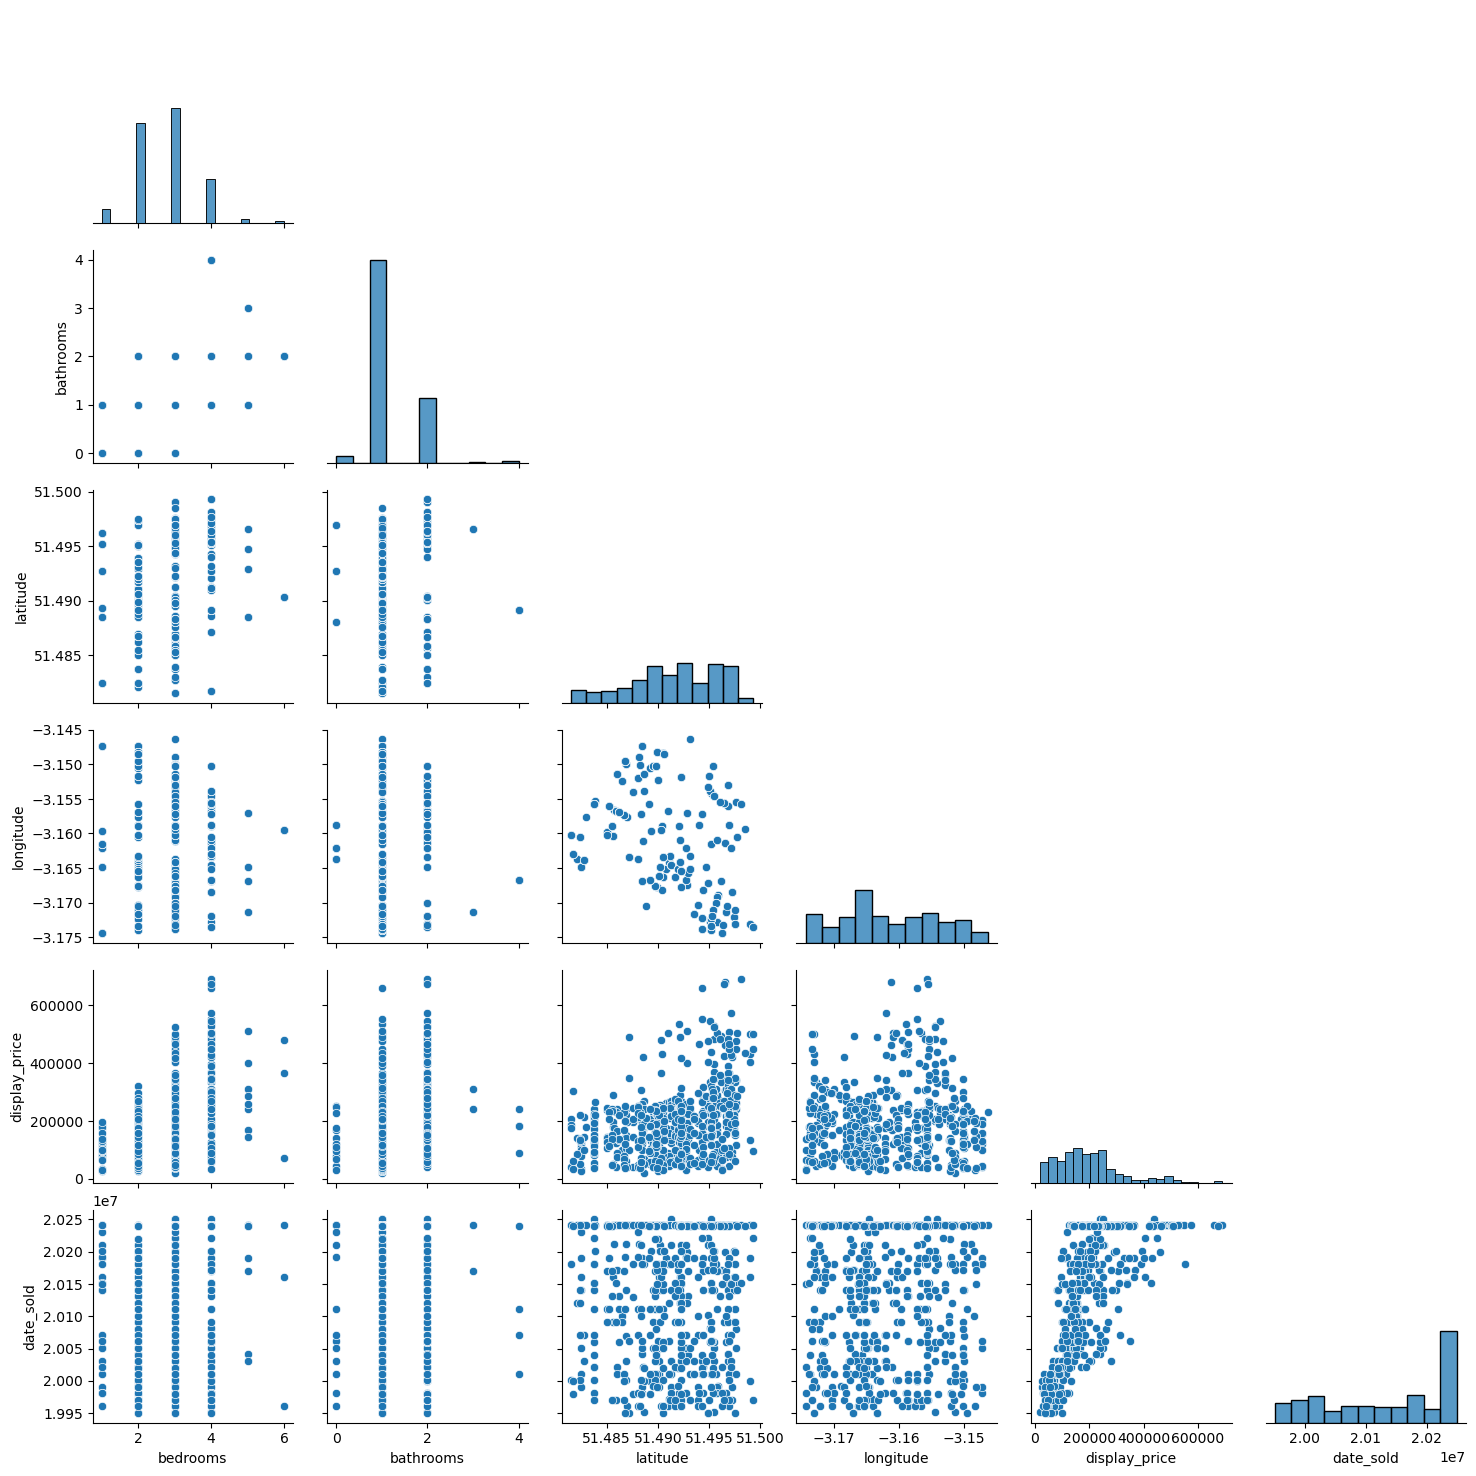

In [9]:
sns.pairplot(data=df, corner=True)

### 1.3.2 Trend Plots

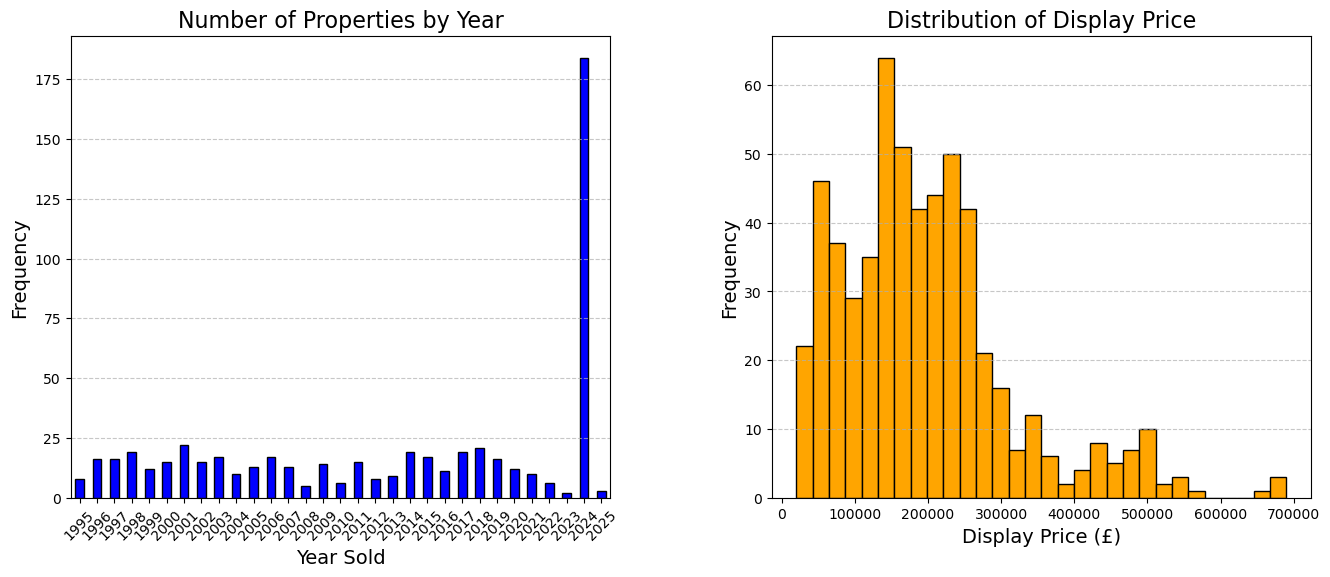

In [10]:
# Extract the year from the 'date_sold' column
df['year_sold'] = pd.to_datetime(df['date_sold'], format='%Y%m%d', errors='coerce').dt.year

fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'wspace': 0.3})

# First subplot: Number of properties by year
df['year_sold'].value_counts().sort_index().plot(kind='bar', edgecolor='black', ax=axes[0], color='blue')
axes[0].set_title('Number of Properties by Year', fontsize=16)
axes[0].set_xlabel('Year Sold', fontsize=14)
axes[0].set_ylabel('Frequency', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Second subplot: Histogram of display_price
axes[1].hist(df['display_price'], bins=30, color='orange', edgecolor='black')
axes[1].set_title('Distribution of Display Price', fontsize=16)
axes[1].set_xlabel('Display Price (£)', fontsize=14)
axes[1].set_ylabel('Frequency', fontsize=14)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

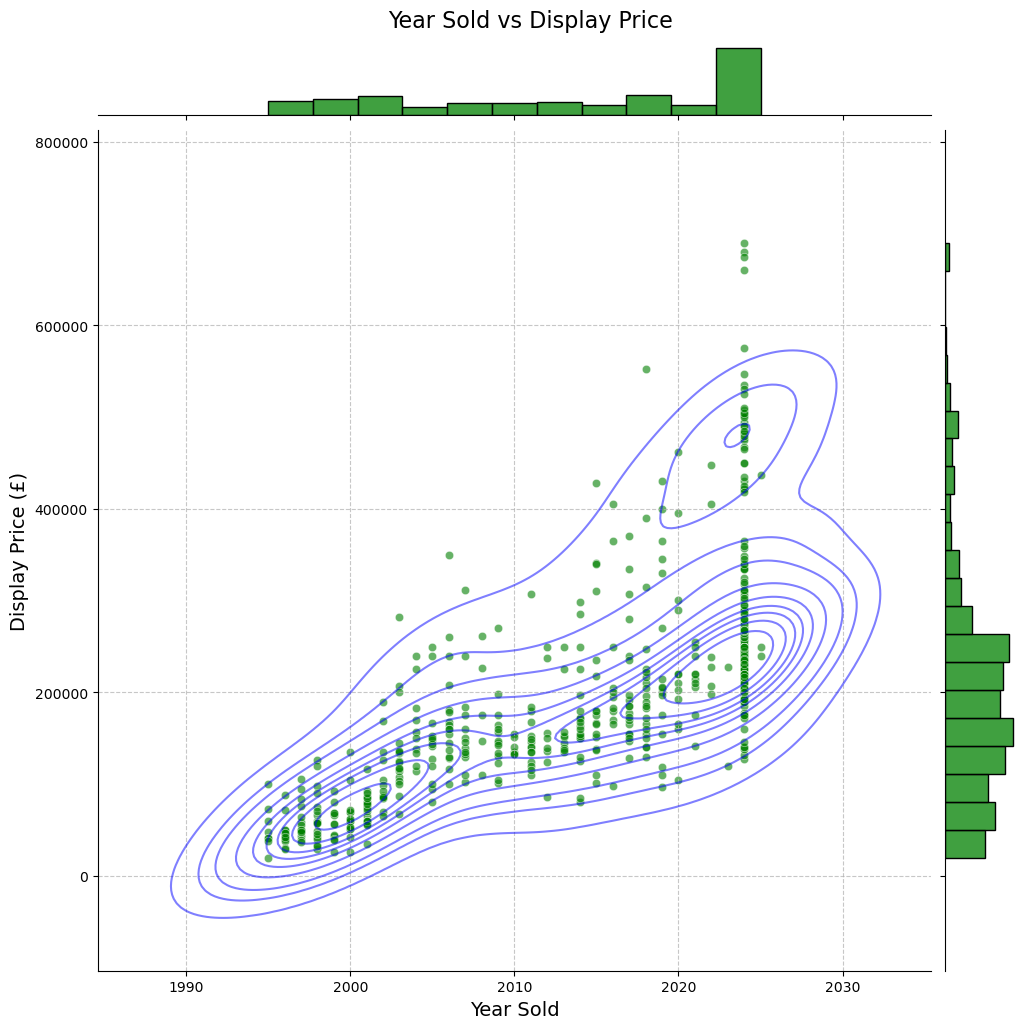

In [11]:
sns.jointplot(data=df,x='year_sold',y='display_price',kind='scatter',alpha=0.6,color='green',height=10, ratio=10) # Generate Scatter and hist
sns.kdeplot(data=df,x='year_sold',y='display_price',levels=10,color='blue',alpha=0.5,)  # KDE plot to generate contour map 

plt.suptitle('Year Sold vs Display Price', y=1.02, fontsize=16)
plt.xlabel('Year Sold', fontsize=14)
plt.ylabel('Display Price (£)', fontsize=14)

# Show the plot
plt.grid(linestyle='--', alpha=0.7)
plt.show()

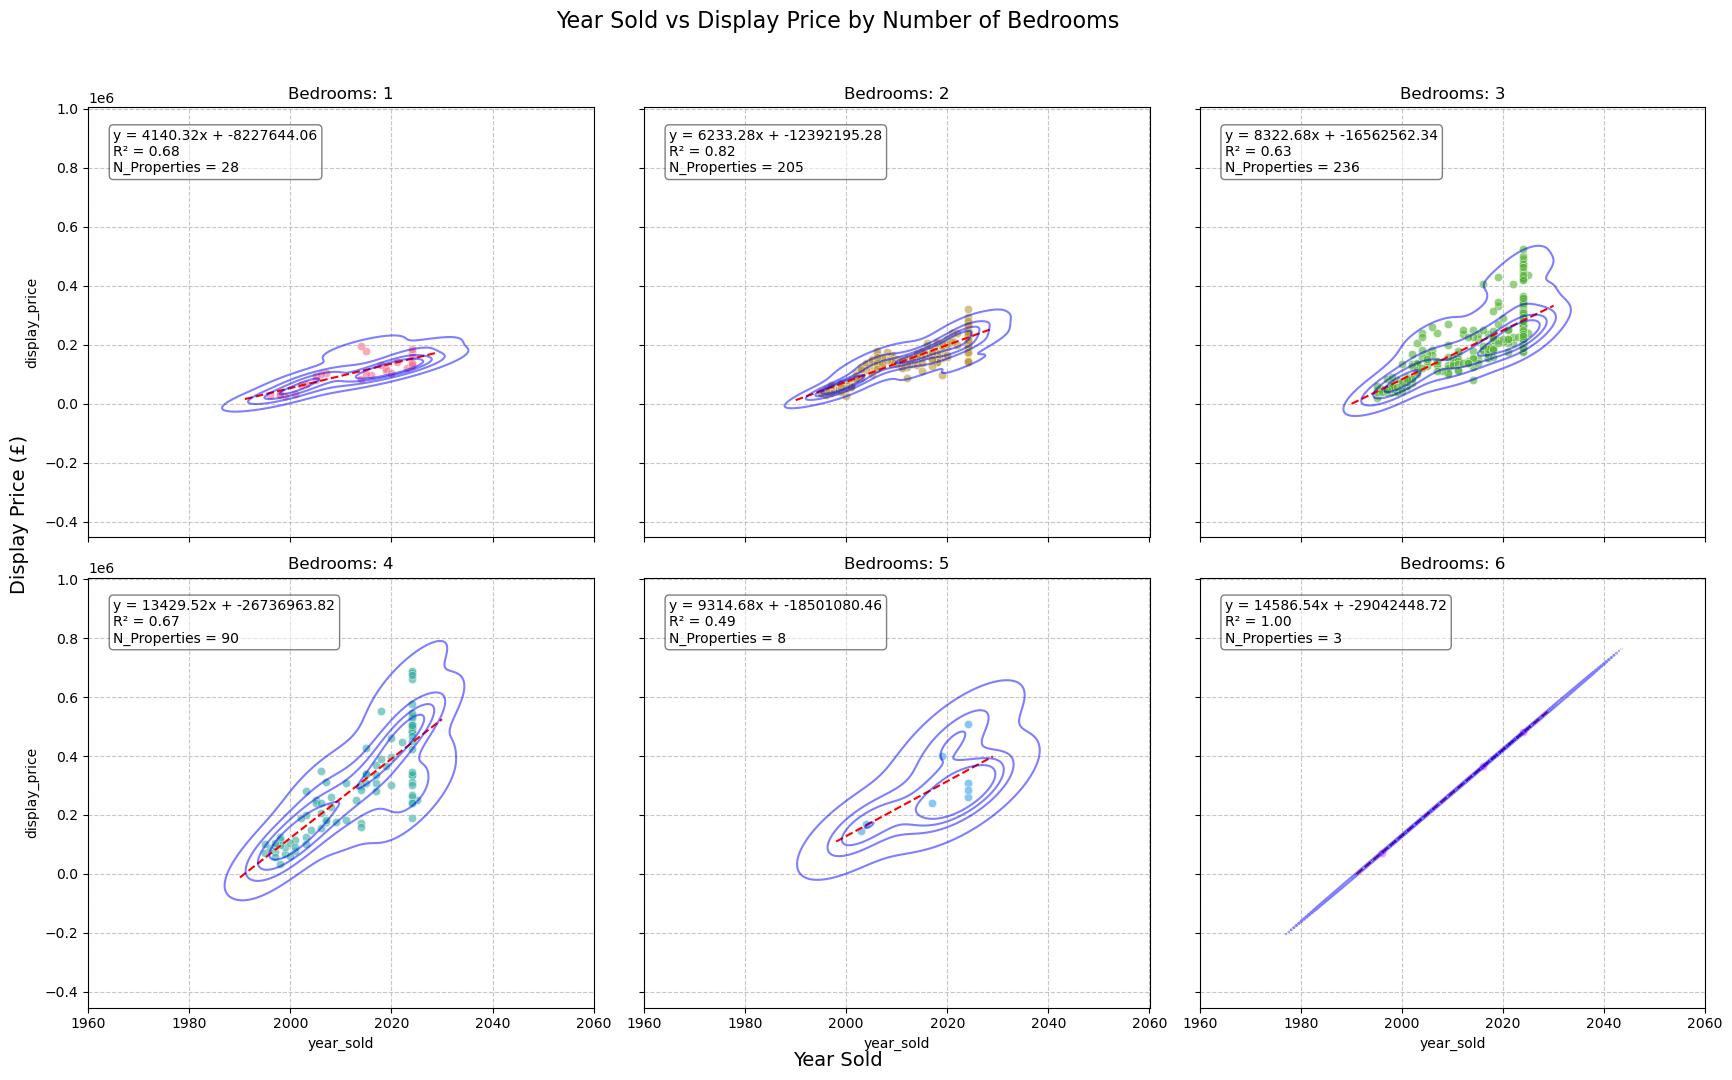

{1: {'m': array([4140.31697]), 'c': -8227644.064117551, 'r2': 0.6758838099252615, 'N': 28}, 2: {'m': array([6233.27889994]), 'c': -12392195.28039379, 'r2': 0.8217105756030633, 'N': 205}, 3: {'m': array([8322.67852082]), 'c': -16562562.344368327, 'r2': 0.6268213632262941, 'N': 236}, 4: {'m': array([13429.51925073]), 'c': -26736963.822666798, 'r2': 0.671956503006311, 'N': 90}, 5: {'m': array([9314.67523831]), 'c': -18501080.458878297, 'r2': 0.49042314792622743, 'N': 8}, 6: {'m': array([14586.53846154]), 'c': -29042448.717948724, 'r2': 0.999982473897695, 'N': 3}}


In [12]:
unique_bedrooms = np.sort(df['bedrooms'].dropna().unique())
bedroom_colors = sns.color_palette("husl", len(unique_bedrooms))

fig, axes = plt.subplots(nrows=int(np.ceil(len(unique_bedrooms) / 3)), ncols=3, figsize=(18, 12), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten the axes array for easy iteration

lin_reg = {}
# Loop through each unique number of bedrooms and plot
for i, bedrooms in enumerate(unique_bedrooms):
    ax = axes[i]
    subset = df[df['bedrooms'] == bedrooms]  # Filter data for the current number of bedrooms
    
    # Scatter plot
    sns.scatterplot(data=subset, x='year_sold', y='display_price', alpha=0.6, ax=ax, color=bedroom_colors[i])
    
    # Fit linear regression
    if len(subset) > 1:  # Ensure there is enough data to fit a regression
        X = subset['year_sold'].values.reshape(-1, 1)
        y_vals = subset['display_price'].values
        reg = LinearRegression().fit(X, y_vals)
        # Extend regression line
        x_range = np.linspace(X.min() - 5, X.max() + 5, 100).reshape(-1, 1)
        y_range = reg.predict(x_range)
        ax.plot(x_range, y_range, color='red', linestyle='--', label='Regression Line')
        
        r2 = reg.score(X, y_vals)
        ax.text(0.05, 0.95, f"y = {reg.coef_[0]:.2f}x + {reg.intercept_:.2f}\nR² = {r2:.2f}\nN_Properties = {len(subset)}",
                transform=ax.transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle="round", alpha=0.5, facecolor="white"))
        
        # Dictionary output
        lin_reg[int(bedrooms)] = {'m': reg.coef_, 'c': reg.intercept_, 'r2': r2, 'N':len(subset)}

    else:
        # Add number of data points if regression is not performed
        ax.text(0.05, 0.95, f"N = {len(subset)}",
                transform=ax.transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle="round", alpha=0.5, facecolor="white"))

    # KDE plot
    sns.kdeplot(data=subset, x='year_sold', y='display_price', levels=5, color='blue', alpha=0.5, ax=ax)
    
    ax.set_title(f"Bedrooms: {int(bedrooms)}")
    ax.grid(linestyle='--', alpha=0.7)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Year Sold vs Display Price by Number of Bedrooms", y=0.92, fontsize=16)
fig.text(0.5, 0.04, "Year Sold", ha="center", fontsize=14)
fig.text(0.04, 0.5, "Display Price (£)", va="center", rotation="vertical", fontsize=14)

# Show the plot
plt.tight_layout(rect=[0.04, 0.04, 1, 0.9])
plt.show()

print(lin_reg)

C:\Users\roryj\AppData\Local\Temp\ipykernel_31064\680935243.py:41: UserWarning:

KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.



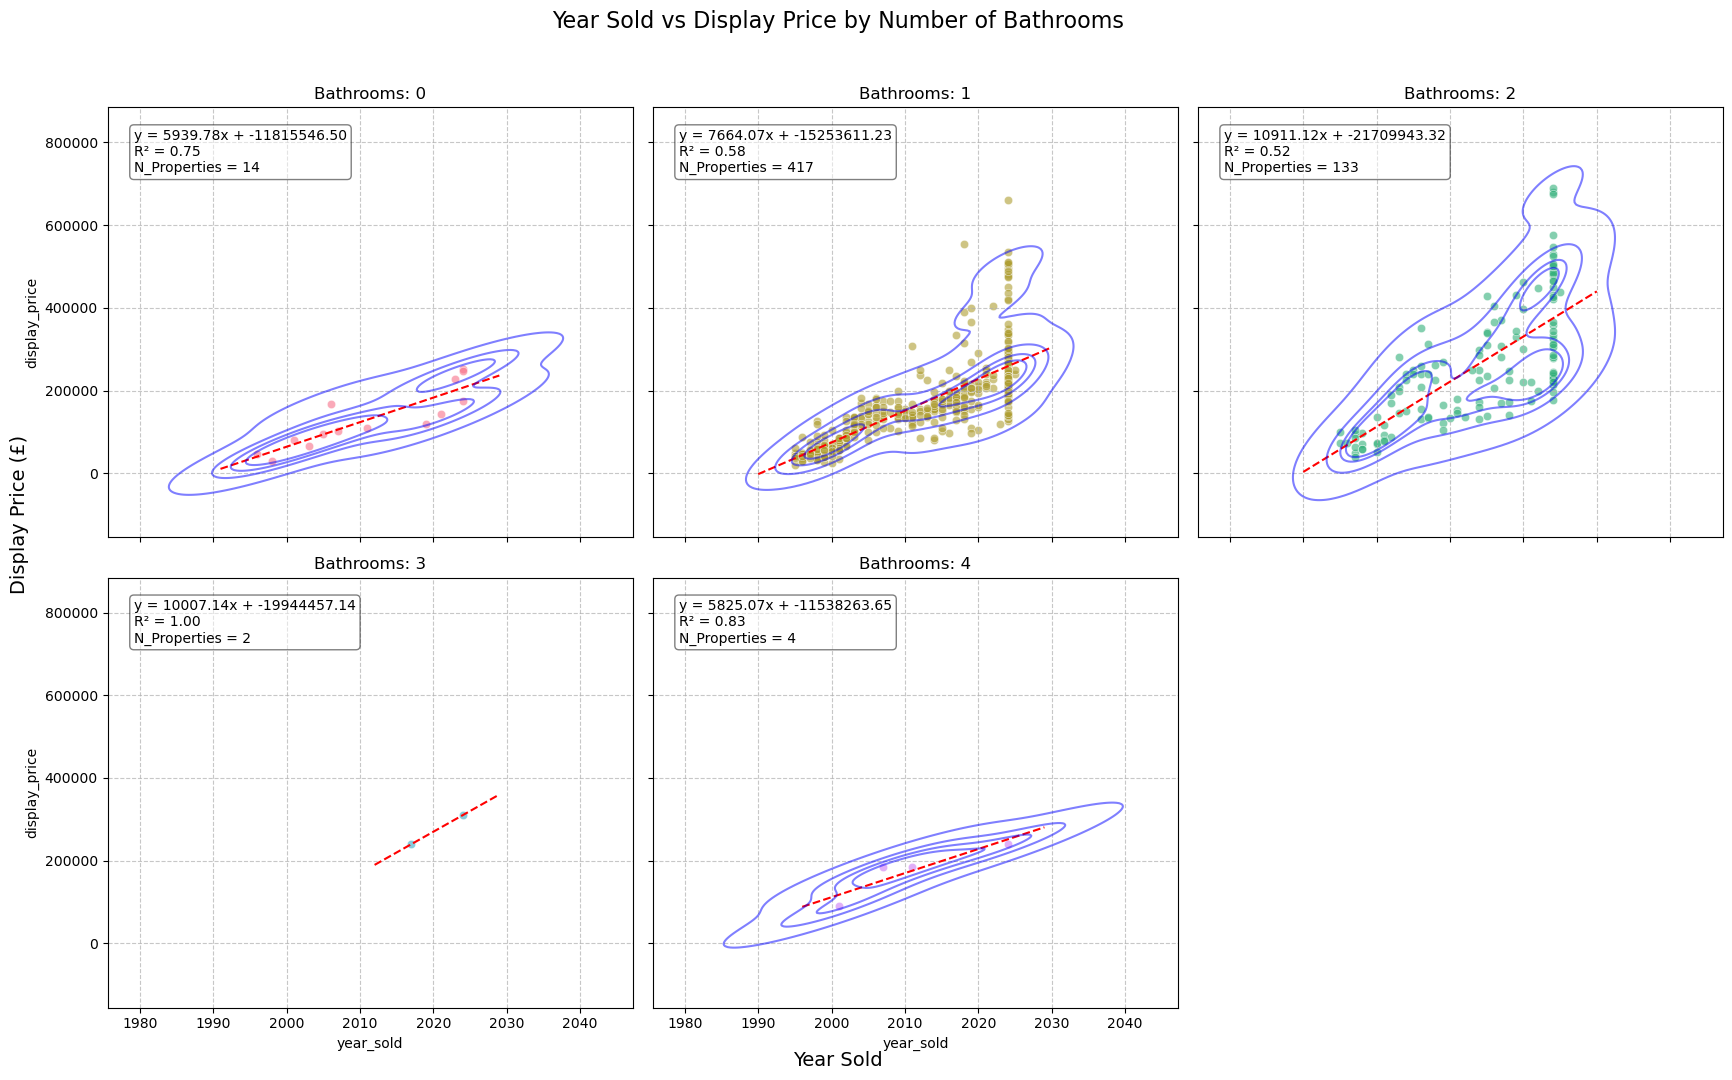

{0: {'m': array([5939.78058905]), 'c': -11815546.496343143, 'r2': 0.7512952232615716, 'N': 14}, 1: {'m': array([7664.06551032]), 'c': -15253611.229523059, 'r2': 0.583706116064294, 'N': 417}, 2: {'m': array([10911.12333399]), 'c': -21709943.31811182, 'r2': 0.5175839904482806, 'N': 133}, 3: {'m': array([10007.14285714]), 'c': -19944457.142857146, 'r2': 1.0, 'N': 2}, 4: {'m': array([5825.06584723]), 'c': -11538263.6523266, 'r2': 0.8322067818051467, 'N': 4}}


In [13]:
unique_bathrooms = np.sort(df['bathrooms'].dropna().unique())
bathroom_colors = sns.color_palette("husl", len(unique_bathrooms))

fig, axes = plt.subplots(nrows=int(np.ceil(len(unique_bathrooms) / 3)), ncols=3, figsize=(18, 12), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten the axes array for easy iteration

lin_reg_bathrooms = {}
# Loop through each unique number of bathrooms and plot
for i, bathrooms in enumerate(unique_bathrooms):
    ax = axes[i]
    subset = df[df['bathrooms'] == bathrooms]  # Filter data for the current number of bathrooms
    
    # Scatter plot
    sns.scatterplot(data=subset, x='year_sold', y='display_price', alpha=0.6, ax=ax, color=bathroom_colors[i])
    
    # Fit linear regression
    if len(subset) > 1:  # Ensure there is enough data to fit a regression
        X = subset['year_sold'].values.reshape(-1, 1)
        y_vals = subset['display_price'].values
        reg = LinearRegression().fit(X, y_vals)
        # Extend regression line
        x_range = np.linspace(X.min() - 5, X.max() + 5, 100).reshape(-1, 1)
        y_range = reg.predict(x_range)
        ax.plot(x_range, y_range, color='red', linestyle='--', label='Regression Line')
        
        r2 = reg.score(X, y_vals)
        ax.text(0.05, 0.95, f"y = {reg.coef_[0]:.2f}x + {reg.intercept_:.2f}\nR² = {r2:.2f}\nN_Properties = {len(subset)}",
                transform=ax.transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle="round", alpha=0.5, facecolor="white"))
        
        # Dictionary output
        lin_reg_bathrooms[int(bathrooms)] = {'m': reg.coef_, 'c': reg.intercept_, 'r2': r2, 'N':len(subset)}

    else:
        # Add number of data points if regression is not performed
        ax.text(0.05, 0.95, f"N = {len(subset)}",
                transform=ax.transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle="round", alpha=0.5, facecolor="white"))

    # KDE plot
    sns.kdeplot(data=subset, x='year_sold', y='display_price', levels=5, color='blue', alpha=0.5, ax=ax)
    
    ax.set_title(f"Bathrooms: {int(bathrooms)}")
    ax.grid(linestyle='--', alpha=0.7)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Year Sold vs Display Price by Number of Bathrooms", y=0.92, fontsize=16)
fig.text(0.5, 0.04, "Year Sold", ha="center", fontsize=14)
fig.text(0.04, 0.5, "Display Price (£)", va="center", rotation="vertical", fontsize=14)

# Show the plot
plt.tight_layout(rect=[0.04, 0.04, 1, 0.9])
plt.show()

print(lin_reg_bathrooms)

## 1.4 Linear Regression & Forecasting

c:\Users\roryj\Anaconda3\envs\DataSci\Lib\site-packages\statsmodels\regression\linear_model.py:1717: RuntimeWarning:

divide by zero encountered in scalar divide



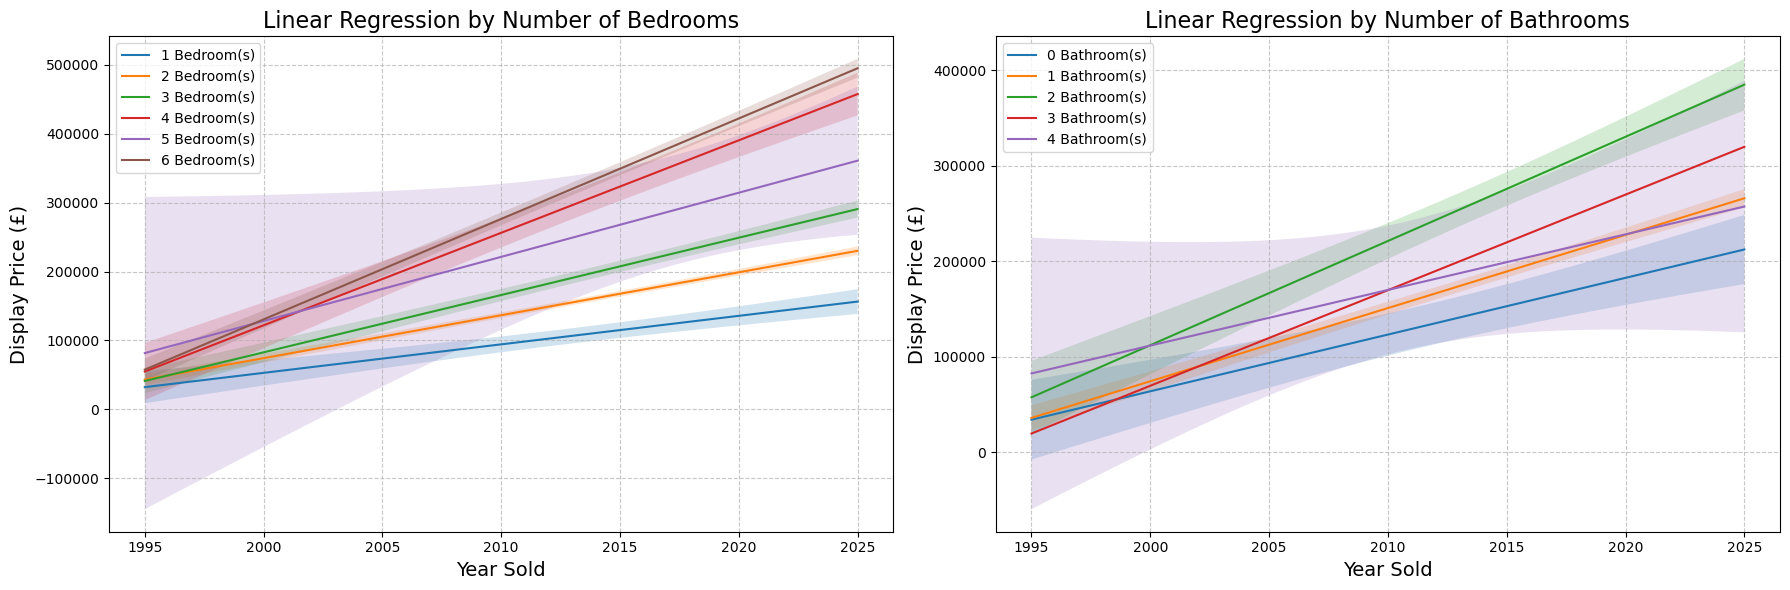

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))  # Create a 1x2 grid of subplots
x_range = np.linspace(df['year_sold'].min(), df['year_sold'].max(), 100)

# Plot 1: Linear regression by Number of Bedrooms
ax = axes[0]
for bedrooms in lin_reg.keys():
    # Filter data for the current number of bedrooms
    subset = df[df['bedrooms'] == bedrooms]
    
    # Fit the regression model using statsmodels
    X = sm.add_constant(subset['year_sold'])  # Add constant for the intercept
    y = subset['display_price']
    model = sm.OLS(y, X).fit()
    
    # Predict values and confidence intervals
    X_pred = sm.add_constant(x_range)  # Add constant to the x_range for predictions
    y_pred = model.predict(X_pred)  # Predicted values
    conf_int = model.get_prediction(X_pred).conf_int()  # Confidence intervals
    
    # Plot the regression line
    ax.plot(x_range, y_pred, label=f"{int(bedrooms)} Bedroom(s)")
    
    # Plot the confidence intervals as a shaded region
    ax.fill_between(x_range, conf_int[:, 0], conf_int[:, 1], alpha=0.2)

# Add labels, title, and legend
ax.set_title('Linear Regression by Number of Bedrooms', fontsize=16)
ax.set_xlabel('Year Sold', fontsize=14)
ax.set_ylabel('Display Price (£)', fontsize=14)
ax.legend(loc='best', fontsize=10)
ax.grid(linestyle='--', alpha=0.7)

# Plot 2: Linear regression by Number of Bathrooms
ax = axes[1]
for bathrooms in sorted(df['bathrooms'].unique()):
    # Filter data for the current number of bathrooms
    subset = df[df['bathrooms'] == bathrooms]
    
    # Fit the regression model using statsmodels
    X = sm.add_constant(subset['year_sold'])  # Add constant for the intercept
    y = subset['display_price']
    model = sm.OLS(y, X).fit()
    
    # Predict values and confidence intervals
    X_pred = sm.add_constant(x_range)  # Add constant to the x_range for predictions
    y_pred = model.predict(X_pred)  # Predicted values
    conf_int = model.get_prediction(X_pred).conf_int()  # Confidence intervals
    
    # Plot the regression line
    ax.plot(x_range, y_pred, label=f"{int(bathrooms)} Bathroom(s)")
    
    # Plot the confidence intervals as a shaded region
    ax.fill_between(x_range, conf_int[:, 0], conf_int[:, 1], alpha=0.2)

ax.set_title('Linear Regression by Number of Bathrooms', fontsize=16)
ax.set_xlabel('Year Sold', fontsize=14)
ax.set_ylabel('Display Price (£)', fontsize=14)
ax.legend(loc='best', fontsize=10)
ax.grid(linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

C:\Users\roryj\AppData\Local\Temp\ipykernel_31064\7650179.py:36: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\roryj\AppData\Local\Temp\ipykernel_31064\7650179.py:36: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\roryj\AppData\Local\Temp\ipykernel_31064\7650179.py:36: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\roryj\AppData\Local\Temp\ipykernel_31064\7650179.py:36: FutureWarning:

Series.__getitem__ tre

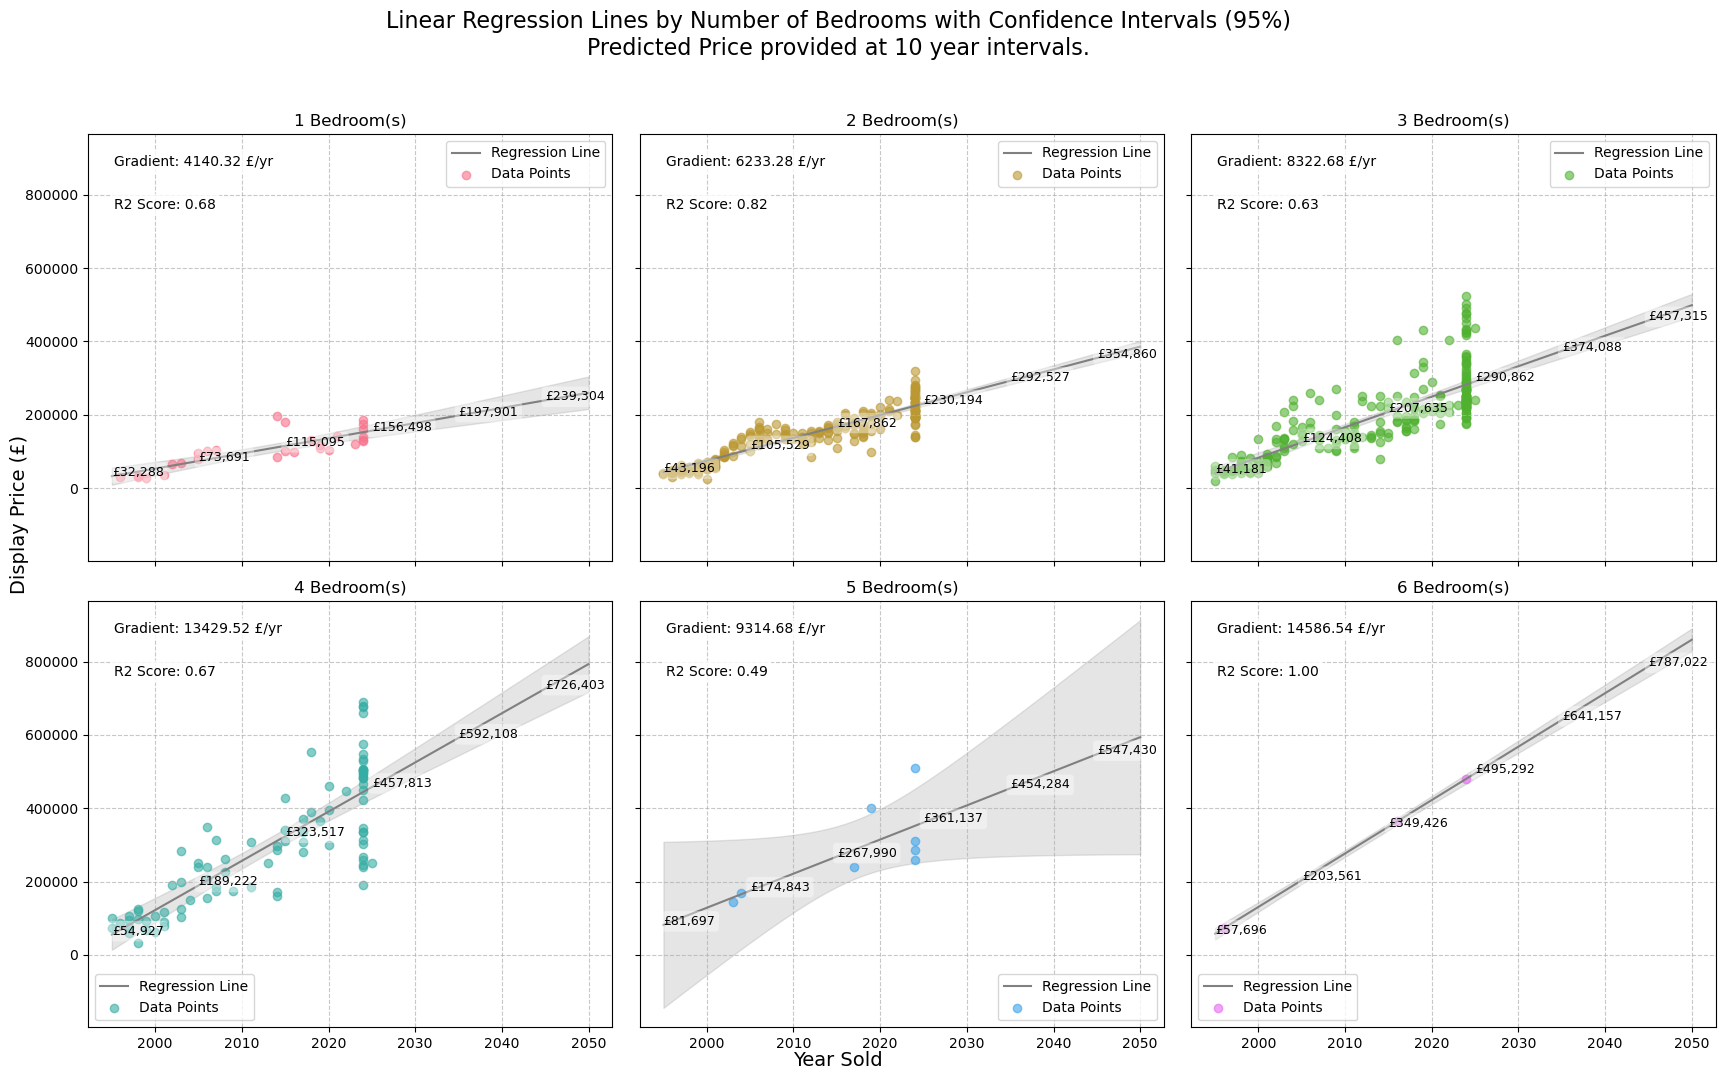

In [15]:
fig, axes = plt.subplots(nrows=int(np.ceil(len(lin_reg.keys()) / 3)), ncols=3, figsize=(18, 12), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten the axes array for easy iteration

x_range = np.linspace(df['year_sold'].min(), 2050, 100)

# Loop through each bedroom and plot its regression line with confidence intervals
for i, (bedrooms, ax) in enumerate(zip(lin_reg.keys(), axes)):
    # Filter data for the current number of bedrooms
    subset = df[df['bedrooms'] == bedrooms]
    
    # Fit the regression model using statsmodels
    X = sm.add_constant(subset['year_sold'])  # Add constant for the intercept
    y = subset['display_price']
    model = sm.OLS(y, X).fit()
    
    # Predict values and confidence intervals
    X_pred = sm.add_constant(x_range)  # Add constant to the x_range for predictions
    y_pred = model.predict(X_pred)  # Predicted values
    conf_int = model.get_prediction(X_pred).conf_int()  # Confidence intervals
    
    # Plot the regression line
    ax.plot(x_range, y_pred, label='Regression Line', color='gray')
    
    # Plot the confidence intervals as a shaded region
    ax.fill_between(x_range, conf_int[:, 0], conf_int[:, 1], alpha=0.2, color='gray')
    
    # Scatter plot of the data points
    ax.scatter(subset['year_sold'], subset['display_price'], alpha=0.6, label='Data Points', color=bedroom_colors[i])
    
    # Add predicted house price at every 10-year interval
    for year in range(int(df['year_sold'].min()), 2051, 10):
        predicted_price = model.predict([1, year])[0]  # Predict price for the year
        ax.text(year, predicted_price, f"£{predicted_price:,.0f}", fontsize=9, color='k', alpha=1.0, bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='white', alpha=0.4))

    # Add gradient (slope) as a text box
    gradient = model.params[1] 
    ax.text(0.05, 0.95, f"Gradient: {gradient:.2f} £/yr", transform=ax.transAxes, fontsize=10, color='k', bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='white', alpha=0.8), verticalalignment='top')
    
     # Add R2 value as a text box
    r_squared = model.rsquared  # Extract the R² value
    ax.text(0.05, 0.85, f"R2 Score: {r_squared:.2f}", transform=ax.transAxes, fontsize=10, color='k', bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='white', alpha=0.8), verticalalignment='top')
    
    # Add title and legend
    ax.set_title(f"{int(bedrooms)} Bedroom(s)")
    ax.legend(fontsize=10)
    ax.grid(linestyle='--', alpha=0.7)

# Remove unused subplots
for j in range(len(lin_reg.keys()), len(axes)):
    fig.delaxes(axes[j])

# Add shared labels and title
fig.suptitle("Linear Regression Lines by Number of Bedrooms with Confidence Intervals (95%)\nPredicted Price provided at 10 year intervals.", y=0.92, fontsize=16)
fig.text(0.5, 0.04, "Year Sold", ha="center", fontsize=14)
fig.text(0.04, 0.5, "Display Price (£)", va="center", rotation="vertical", fontsize=14)

plt.tight_layout(rect=[0.04, 0.04, 1, 0.9])
plt.show()

C:\Users\roryj\AppData\Local\Temp\ipykernel_31064\704997035.py:38: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\roryj\AppData\Local\Temp\ipykernel_31064\704997035.py:38: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\roryj\AppData\Local\Temp\ipykernel_31064\704997035.py:38: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\Users\roryj\Anaconda3\envs\DataSci\Lib\site-packages\statsmodels\regression\linear_model.py:17

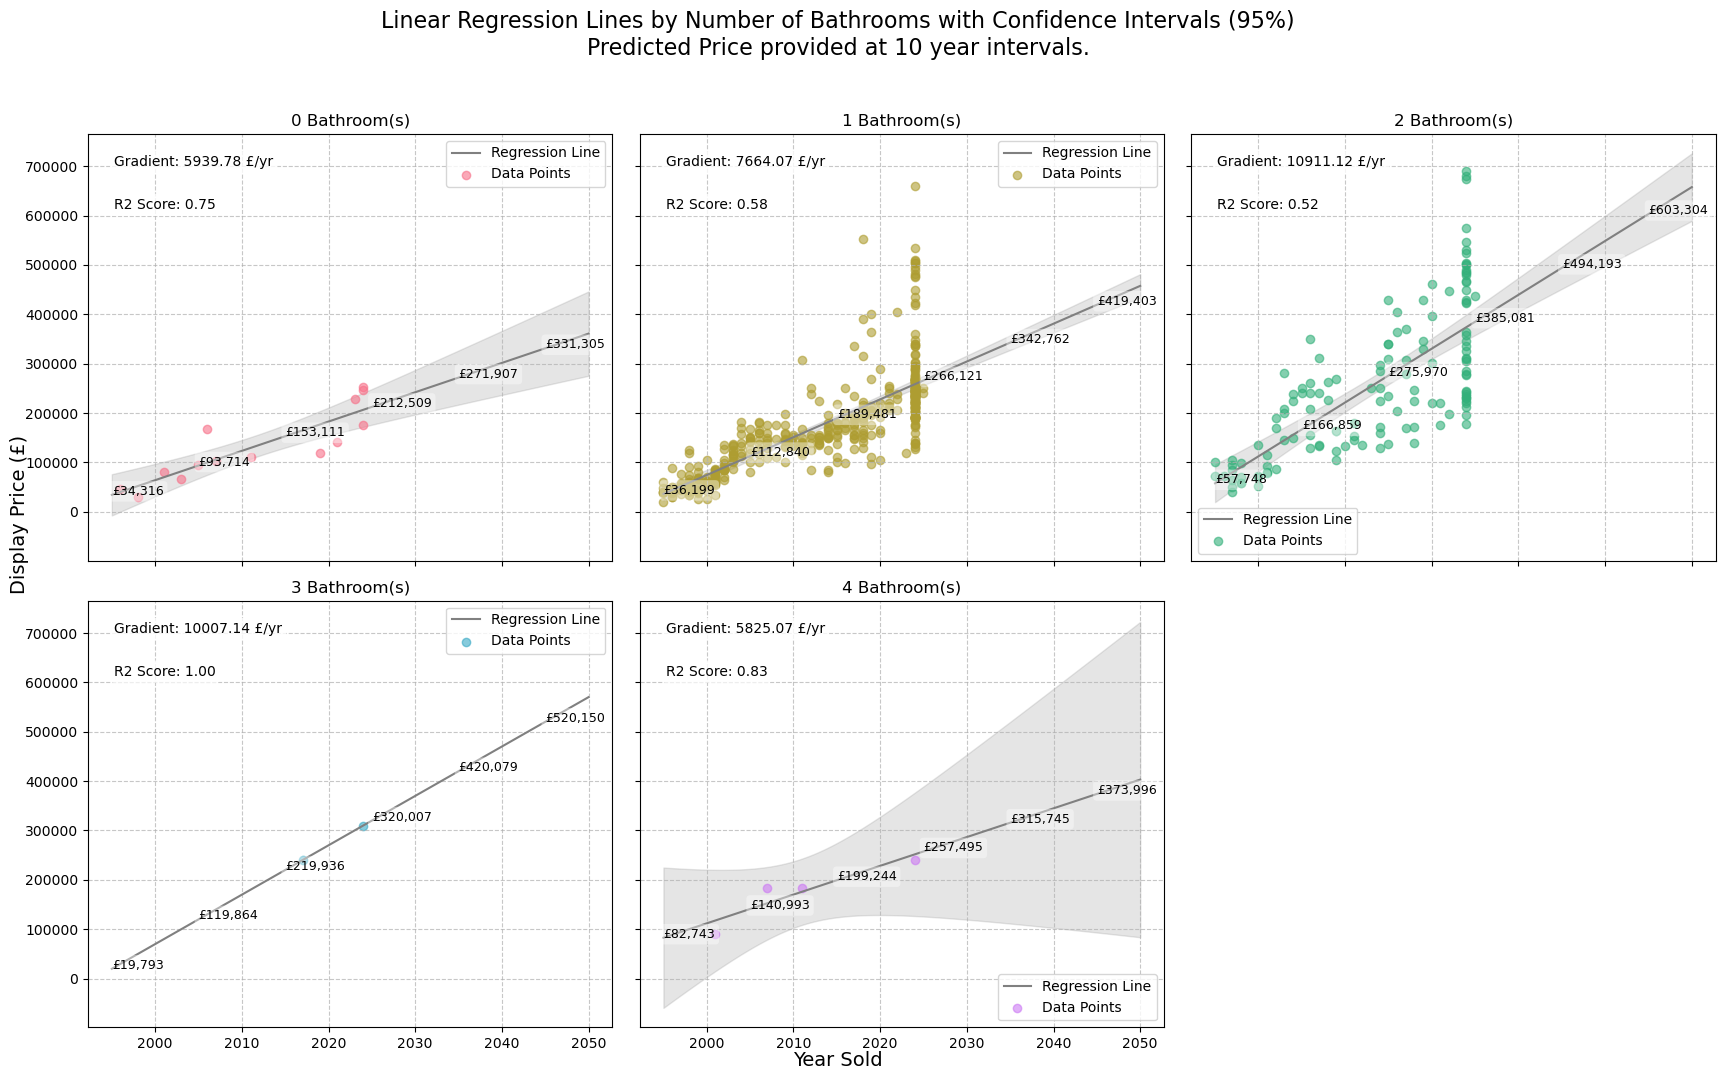

In [16]:
fig, axes = plt.subplots(nrows=int(np.ceil(len(df['bathrooms'].unique()) / 3)), ncols=3, figsize=(18, 12), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten the axes array for easy iteration

x_range = np.linspace(df['year_sold'].min(), 2050, 100)

# Loop through each bathroom count and plot its regression line with confidence intervals
for i, bathrooms in enumerate(sorted(df['bathrooms'].unique())):
    ax = axes[i]
    
    # Filter data for the current number of bathrooms
    subset = df[df['bathrooms'] == bathrooms]
    
    # Fit the regression model using statsmodels
    X = sm.add_constant(subset['year_sold'])  # Add constant for the intercept
    y = subset['display_price']
    model = sm.OLS(y, X).fit()
    
    # Predict values and confidence intervals
    X_pred = sm.add_constant(x_range)  # Add constant to the x_range for predictions
    y_pred = model.predict(X_pred)  # Predicted values
    conf_int = model.get_prediction(X_pred).conf_int()  # Confidence intervals
    
    # Plot the regression line
    ax.plot(x_range, y_pred, label='Regression Line', color='gray')
    
    # Plot the confidence intervals as a shaded region
    ax.fill_between(x_range, conf_int[:, 0], conf_int[:, 1], alpha=0.2, color='gray')
    
    # Scatter plot of the data points
    ax.scatter(subset['year_sold'], subset['display_price'], alpha=0.6, label='Data Points', color=bathroom_colors[i % len(bathroom_colors)])
    
    # Add predicted house price at every 10-year interval
    for year in range(int(df['year_sold'].min()), 2051, 10):
        predicted_price = model.predict([1, year])[0]  # Predict price for the year
        ax.text(year, predicted_price, f"£{predicted_price:,.0f}", fontsize=9, color='k', alpha=1.0, bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='white', alpha=0.4))

    # Add gradient (slope) as a text box
    gradient = model.params[1] 
    ax.text(0.05, 0.95, f"Gradient: {gradient:.2f} £/yr", transform=ax.transAxes, fontsize=10, color='k', bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='white', alpha=0.8), verticalalignment='top')
    
     # Add R2 value as a text box
    r_squared = model.rsquared  # Extract the R² value
    ax.text(0.05, 0.85, f"R2 Score: {r_squared:.2f}", transform=ax.transAxes, fontsize=10, color='k', bbox=dict(boxstyle="round,pad=0.3", edgecolor='none', facecolor='white', alpha=0.8), verticalalignment='top')
    
    # Add title and legend
    ax.set_title(f"{int(bathrooms)} Bathroom(s)")
    ax.legend(fontsize=10)
    ax.grid(linestyle='--', alpha=0.7)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add shared labels and title
fig.suptitle("Linear Regression Lines by Number of Bathrooms with Confidence Intervals (95%)\nPredicted Price provided at 10 year intervals.", y=0.92, fontsize=16)
fig.text(0.5, 0.04, "Year Sold", ha="center", fontsize=14)
fig.text(0.04, 0.5, "Display Price (£)", va="center", rotation="vertical", fontsize=14)

plt.tight_layout(rect=[0.04, 0.04, 1, 0.9])
plt.show()

## 1.5 Housing Type

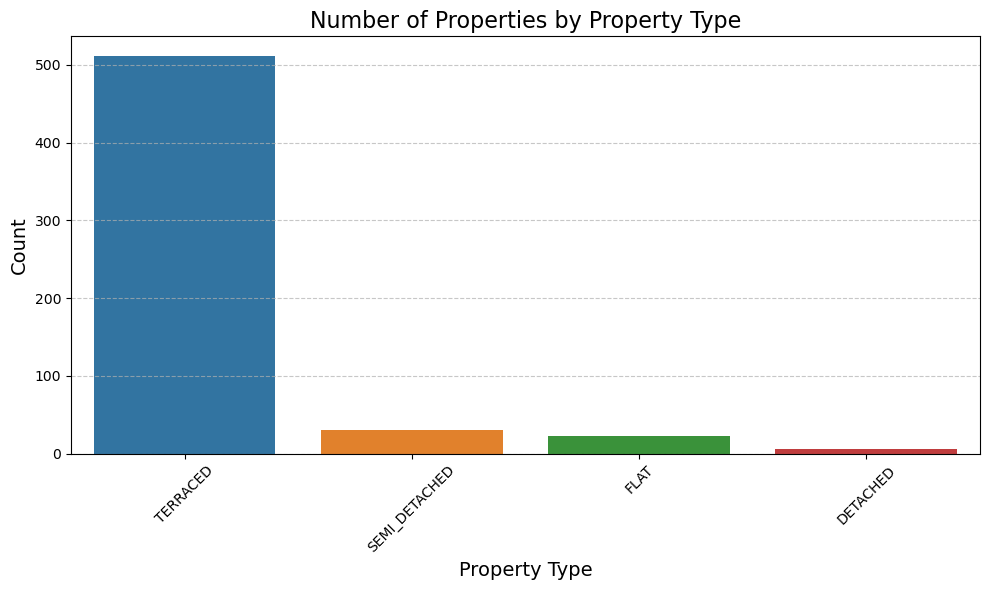

In [17]:
property_type_counts = df['propertyType'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=property_type_counts.index, y=property_type_counts.values, hue=property_type_counts.index, legend=False)
plt.title("Number of Properties by Property Type", fontsize=16)
plt.xlabel("Property Type", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

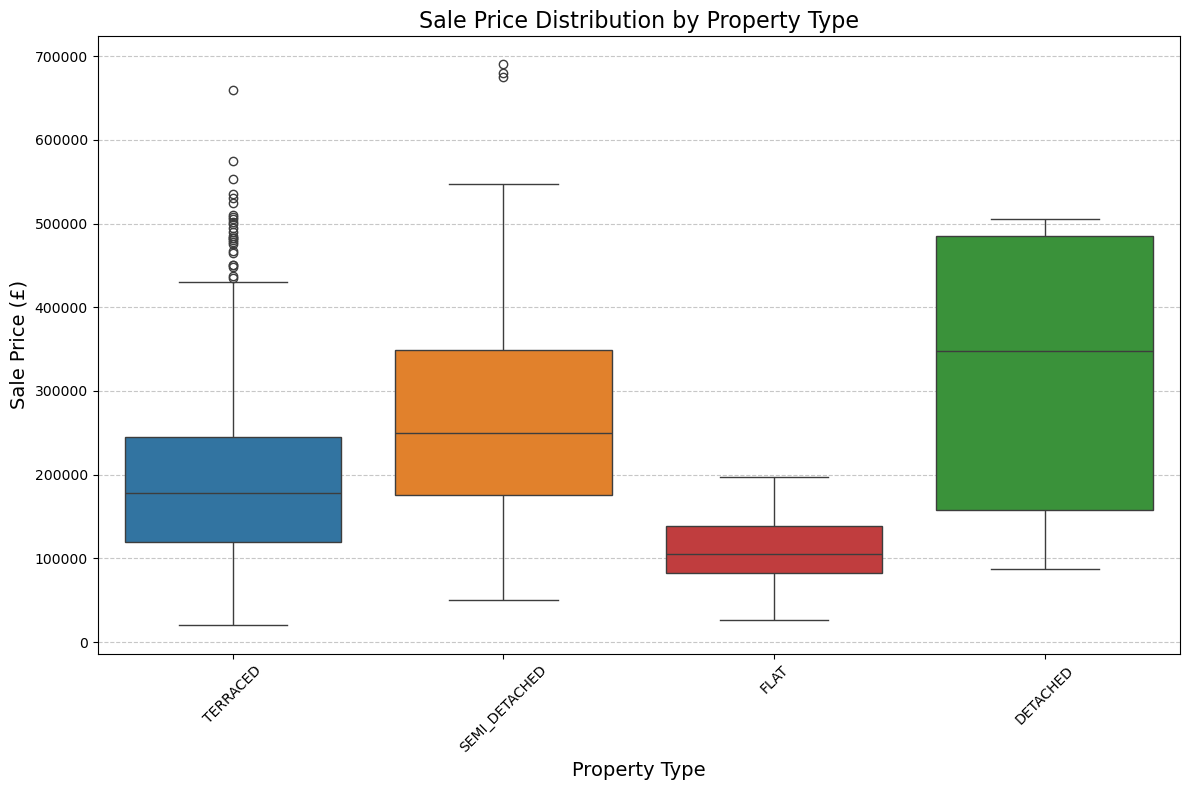

In [18]:
property_type_order = property_type_counts.index

plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='propertyType', y='display_price', hue=df['propertyType'], legend=False, order=property_type_order)

plt.title("Sale Price Distribution by Property Type", fontsize=16)
plt.xlabel("Property Type", fontsize=14)
plt.ylabel("Sale Price (£)", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 1.6 Feature Importances

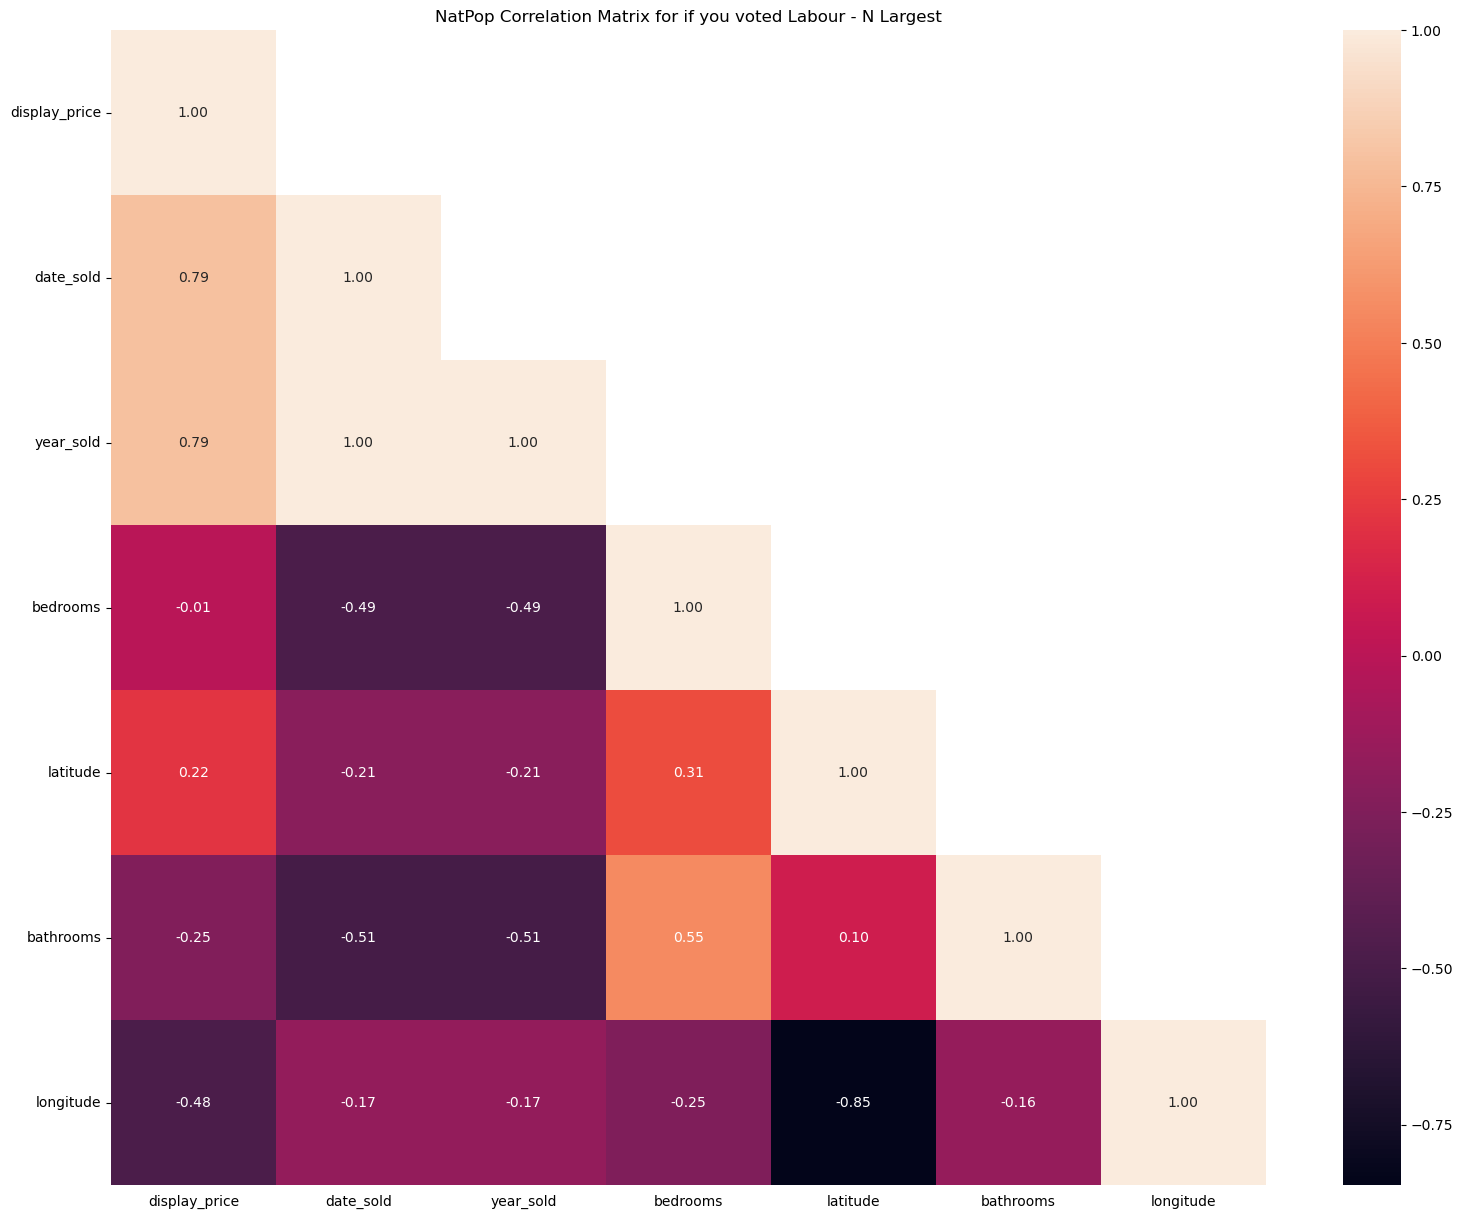

In [19]:
df_numeric = df.select_dtypes(include=['int64','int32', 'float32', 'float64'])
corr_matrix = df_numeric.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

k = 10 #number of variables for heatmap
top_cols = corr_matrix.nlargest(k, 'display_price').index

cm_n = np.corrcoef(corr_matrix[top_cols].values.T)
fig, axes = plt.subplots(1, 1, figsize=(20, 15))

hm = sns.heatmap(cm_n, ax=axes, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=top_cols.values, xticklabels=top_cols.values, mask=mask)
hm.tick_params(left=True, bottom=False, labelleft=True, labelbottom=True, right=False, top=False, labelright=False, labeltop=False, labelrotation=0)
axes.set_title('NatPop Correlation Matrix for if you voted Labour - N Largest')

plt.tight_layout
plt.show()

# 2. Forecasting

In [20]:
propType_label_encoder = LabelEncoder()
encoded_df = df.copy()
encoded_df['propertyType'] = propType_label_encoder.fit_transform(encoded_df['propertyType'])  # Encode property type as labels
encoded_df.set_index('address')

,propertyType,bedrooms,bathrooms,latitude,longitude,display_price,date_sold,year_sold
address,,,,,,,,
"9, Stallcourt Avenue, Cardiff CF23 5AL",3,3.0,2.0,51.49517,-3.15421,437000.0,20250110,2025
"9, Stallcourt Avenue, Cardiff CF23 5AL",3,3.0,2.0,51.49517,-3.15421,330000.0,20190418,2019
"87, Clifton Street, Cardiff CF24 1LT",3,3.0,1.0,51.48374,-3.15580,240000.0,20250110,2025
"87, Clifton Street, Cardiff CF24 1LT",3,3.0,1.0,51.48374,-3.15580,207000.0,20221028,2022
"87, Clifton Street, Cardiff CF24 1LT",3,3.0,1.0,51.48374,-3.15580,151000.0,20150723,2015
...,...,...,...,...,...,...,...,...
"43, Inverness Place, Cardiff CF24 4RU",3,2.0,1.0,51.49356,-3.17160,217000.0,20240315,2024
"43, Inverness Place, Cardiff CF24 4RU",3,2.0,1.0,51.49356,-3.17160,206000.0,20190830,2019
"43, Inverness Place, Cardiff CF24 4RU",3,2.0,1.0,51.49356,-3.17160,159950.0,20061201,2006


In [36]:
# Define features (X) and target (y)
X = encoded_df[['year_sold', 'bedrooms', 'propertyType', 'bathrooms']]
y = encoded_df['display_price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_frac, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

## 2.1 Linear Regression
Okay, I know I already did the Linear Regression above. But let's do it proper as an ML model rather than just fitting it to the entire set.

In [22]:
# Add interaction terms
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_interaction = poly.fit_transform(X_train_scaled)
X_test_interaction = poly.fit_transform(X_test_scaled)

def get_lin_reg(k):
    # Select the top k features
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train_interaction, y_train)
    X_test_selected = selector.transform(X_test_interaction)

    # Use X_selected for training and testing

    # Train the linear regression model
    ridge = Ridge()

    param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}
    ridge_cv = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
    ridge_cv.fit(X_train_selected, y_train)

    # Make predictions
    y_pred_ridge = ridge_cv.predict(X_test_selected)

    r2_ridge = r2_score(y_test, y_pred_ridge)  # Ridge
    return ridge_cv, y_pred_ridge, r2_ridge

k_best_r2 = 0
k_best = 0
for k in range(1, X_train_interaction.shape[1] + 1): # Loop through N features
    _, _, r2 = get_lin_reg(k)
    if r2 > k_best_r2:
        k_best = k
print('Best Number of features:', k_best)
ridge_model, y_pred_ridge, r2_ridge = get_lin_reg(k)        

print("R Squared:", r2_ridge)
mse = mean_squared_error(y_test, y_pred_ridge)
print("Mean Squared Error:", mse)

print("Best alpha for Ridge:", ridge_model.best_params_['alpha'])
# I did also use Lasso and the normal Linear Regression, to be honest, they were all identical down to 3rd decimal place on the R2, I could have picked anyone. 
# But just used ridge as it was technically 'the best'

Best Number of features: 10
R Squared: 0.7936516187809969
Mean Squared Error: 2859663222.258638
Best alpha for Ridge: 10


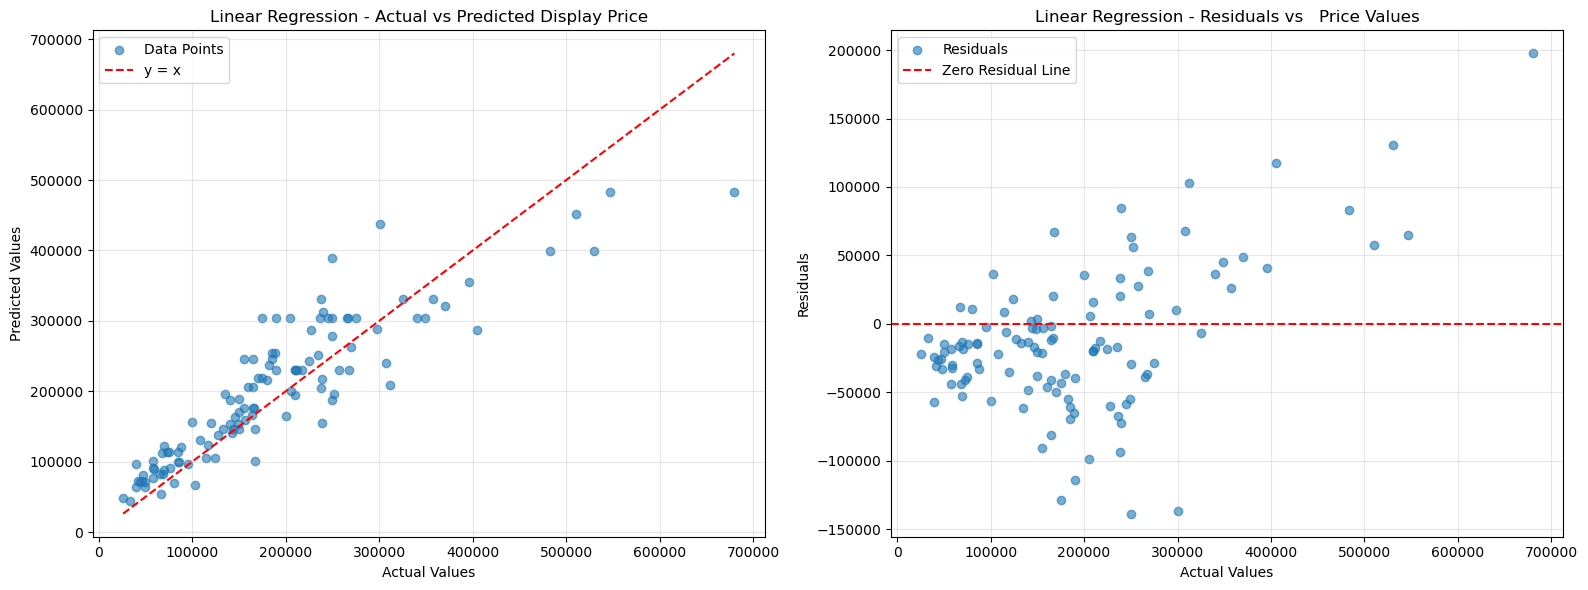

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Subplot 1: Actual vs Predicted Values
ax = axes[0]
ax.scatter(y_test, y_pred_ridge, alpha=0.6, label="Data Points")
ax.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()],color='red',linestyle='--',label="y = x") 
ax.set_title("Linear Regression - Actual vs Predicted Display Price")
ax.set_xlabel("Actual Values")
ax.set_ylabel("Predicted Values")
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Subplot 2: Residuals vs Actual Values
ax = axes[1]
residuals = y_test - y_pred_ridge
ax.scatter(y_test, residuals, alpha=0.6, label="Residuals")
ax.axhline(0, color='red', linestyle='--', label="Zero Residual Line") 
ax.set_title("Linear Regression - Residuals vs   Price Values")
ax.set_xlabel("Actual Values")
ax.set_ylabel("Residuals")
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

C:\Users\roryj\AppData\Local\Temp\ipykernel_31064\1704614438.py:11: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "-ok" (-> marker='o'). The keyword argument will take precedence.



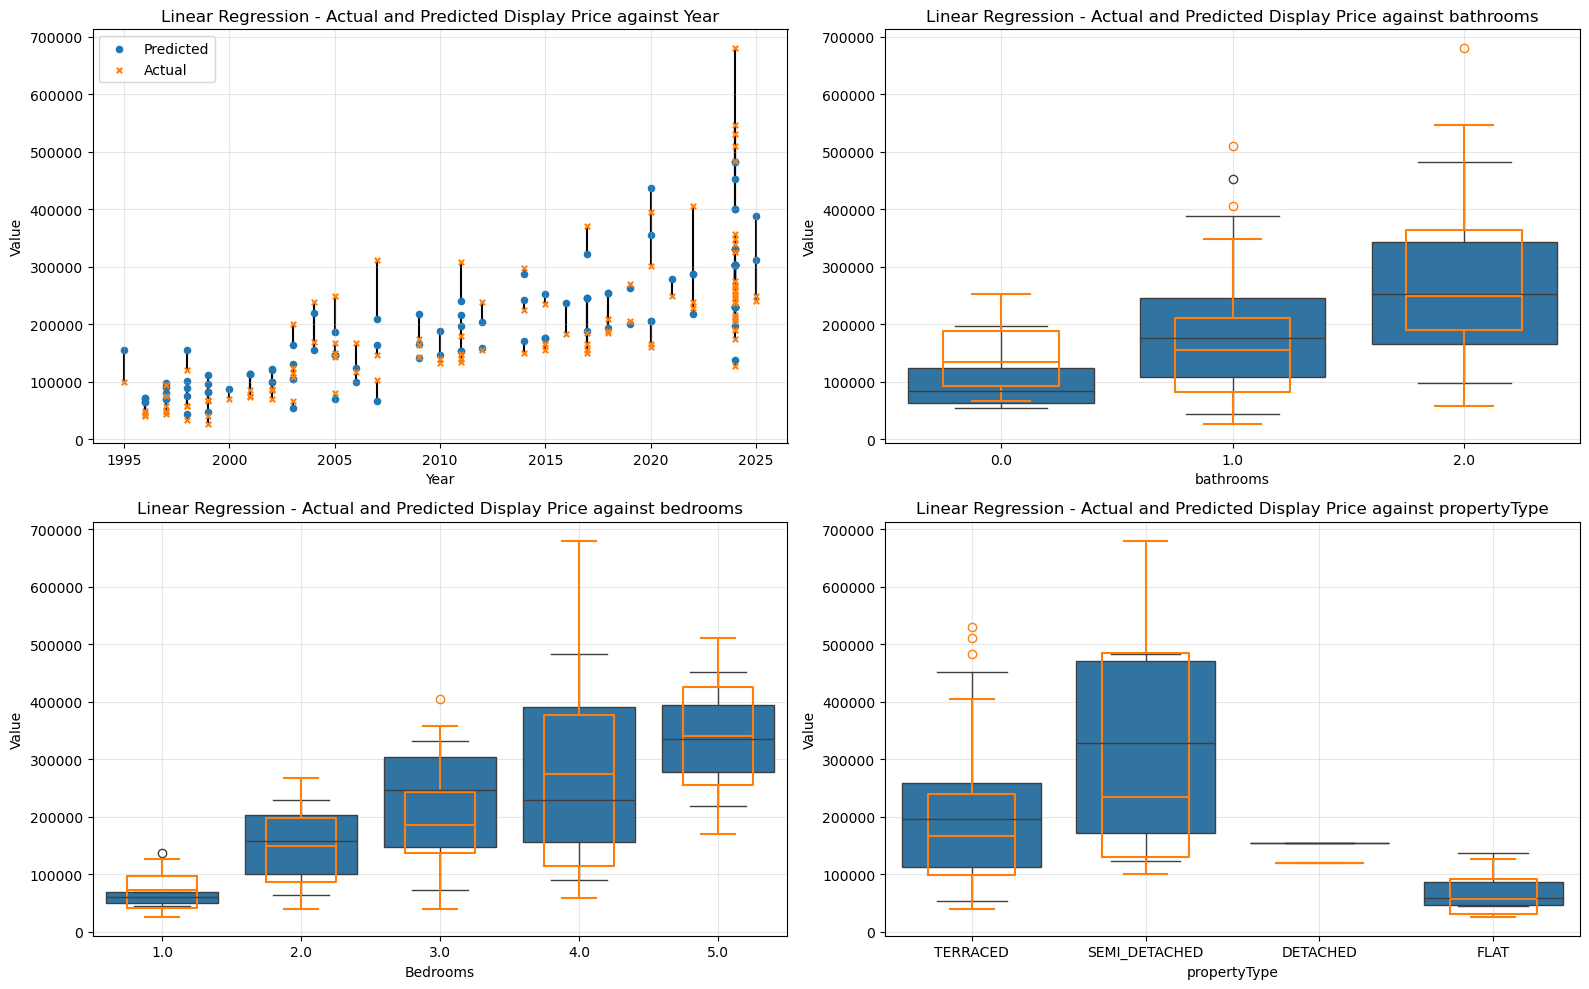

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

temp_df = X_test.copy()
temp_df['pred'] = y_pred_ridge
temp_df['actual'] = y_test

# Subplot 1: Actual and Predicted against Year
ax = axes[0,0]
xx = np.vstack([X_test['year_sold'],X_test['year_sold']])
yy = np.vstack([y_pred_ridge,y_test])
ax.plot(xx,yy, '-ok', mfc='C1', mec='C1',marker=None, zorder=1)
ax.scatter(X_test['year_sold'], y_pred_ridge, s=20, label="Predicted")
ax.scatter(X_test['year_sold'], y_test, s=15, marker='x', label="Actual")
ax.set_title("Linear Regression - Actual and Predicted Display Price against Year")
ax.set_xlabel("Year")
ax.set_ylabel("Value")
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Subplot 2: Actual and Predicted against Year
ax = axes[1,0]
pred_prop_strip = sns.boxplot(ax=ax, x=temp_df['bedrooms'], y=temp_df['pred'])
actu_prop_strip = sns.boxplot(ax=ax, x=temp_df['bedrooms'], y=temp_df['actual'], width=0.5, fill=False)
ax.set_title("Linear Regression - Actual and Predicted Display Price against bedrooms")
ax.set_xlabel("Bedrooms")
ax.set_ylabel("Value")
ax.grid(alpha=0.3)

# Subplot 3: Actual and Predicted against Year
ax = axes[0,1]
pred_prop_strip = sns.boxplot(ax=ax, x=temp_df['bathrooms'], y=temp_df['pred'])
actu_prop_strip = sns.boxplot(ax=ax, x=temp_df['bathrooms'], y=temp_df['actual'], width=0.5, fill=False)
ax.set_title("Linear Regression - Actual and Predicted Display Price against bathrooms")
ax.set_xlabel("bathrooms")
ax.set_ylabel("Value")
ax.grid(alpha=0.3)

# Subplot 4: Actual and Predicted against propertyType
ax = axes[1,1]
pred_prop_strip = sns.boxplot(ax=ax, x=propType_label_encoder.inverse_transform(temp_df['propertyType']), y=temp_df['pred'])
actu_prop_strip = sns.boxplot(ax=ax, x=propType_label_encoder.inverse_transform(temp_df['propertyType']), y=temp_df['actual'], width=0.5, fill=False)
ax.set_title("Linear Regression - Actual and Predicted Display Price against propertyType")
ax.set_xlabel("propertyType")
ax.set_ylabel("Value")
ax.grid(alpha=0.3)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## 2.2 Random Forest

In [25]:
# Init the param grid and the model
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Train a random forest regressor
rf_model = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

rf_model = RandomForestRegressor(**best_params, random_state=random_code)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred_rf)
print("R Squared:", r2)
mse = mean_squared_error(y_test, y_pred_rf)
print("Mean Squared Error:", mse)

Fitting 3 folds for each of 540 candidates, totalling 1620 fits
Best parameters found:  {'bootstrap': True, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
R Squared: 0.8146456942328536
Mean Squared Error: 2568718437.035052


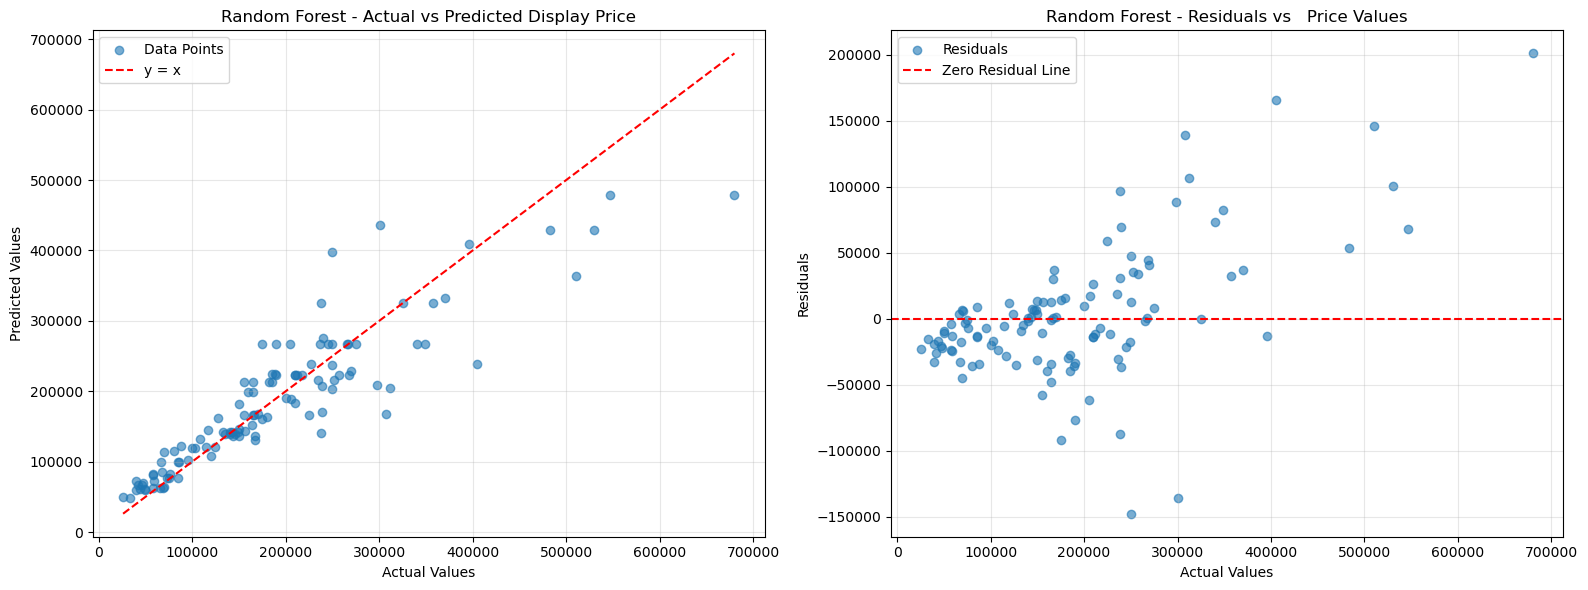

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Subplot 1: Actual vs Predicted Values
ax = axes[0]
ax.scatter(y_test, y_pred_rf, alpha=0.6, label="Data Points")
ax.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()],color='red',linestyle='--',label="y = x") 
ax.set_title("Random Forest - Actual vs Predicted Display Price")
ax.set_xlabel("Actual Values")
ax.set_ylabel("Predicted Values")
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Subplot 2: Residuals vs Actual Values
ax = axes[1]
residuals = y_test - y_pred_rf
ax.scatter(y_test, residuals, alpha=0.6, label="Residuals")
ax.axhline(0, color='red', linestyle='--', label="Zero Residual Line") 
ax.set_title("Random Forest - Residuals vs   Price Values")
ax.set_xlabel("Actual Values")
ax.set_ylabel("Residuals")
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

C:\Users\roryj\AppData\Local\Temp\ipykernel_31064\1184959647.py:11: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "-ok" (-> marker='o'). The keyword argument will take precedence.



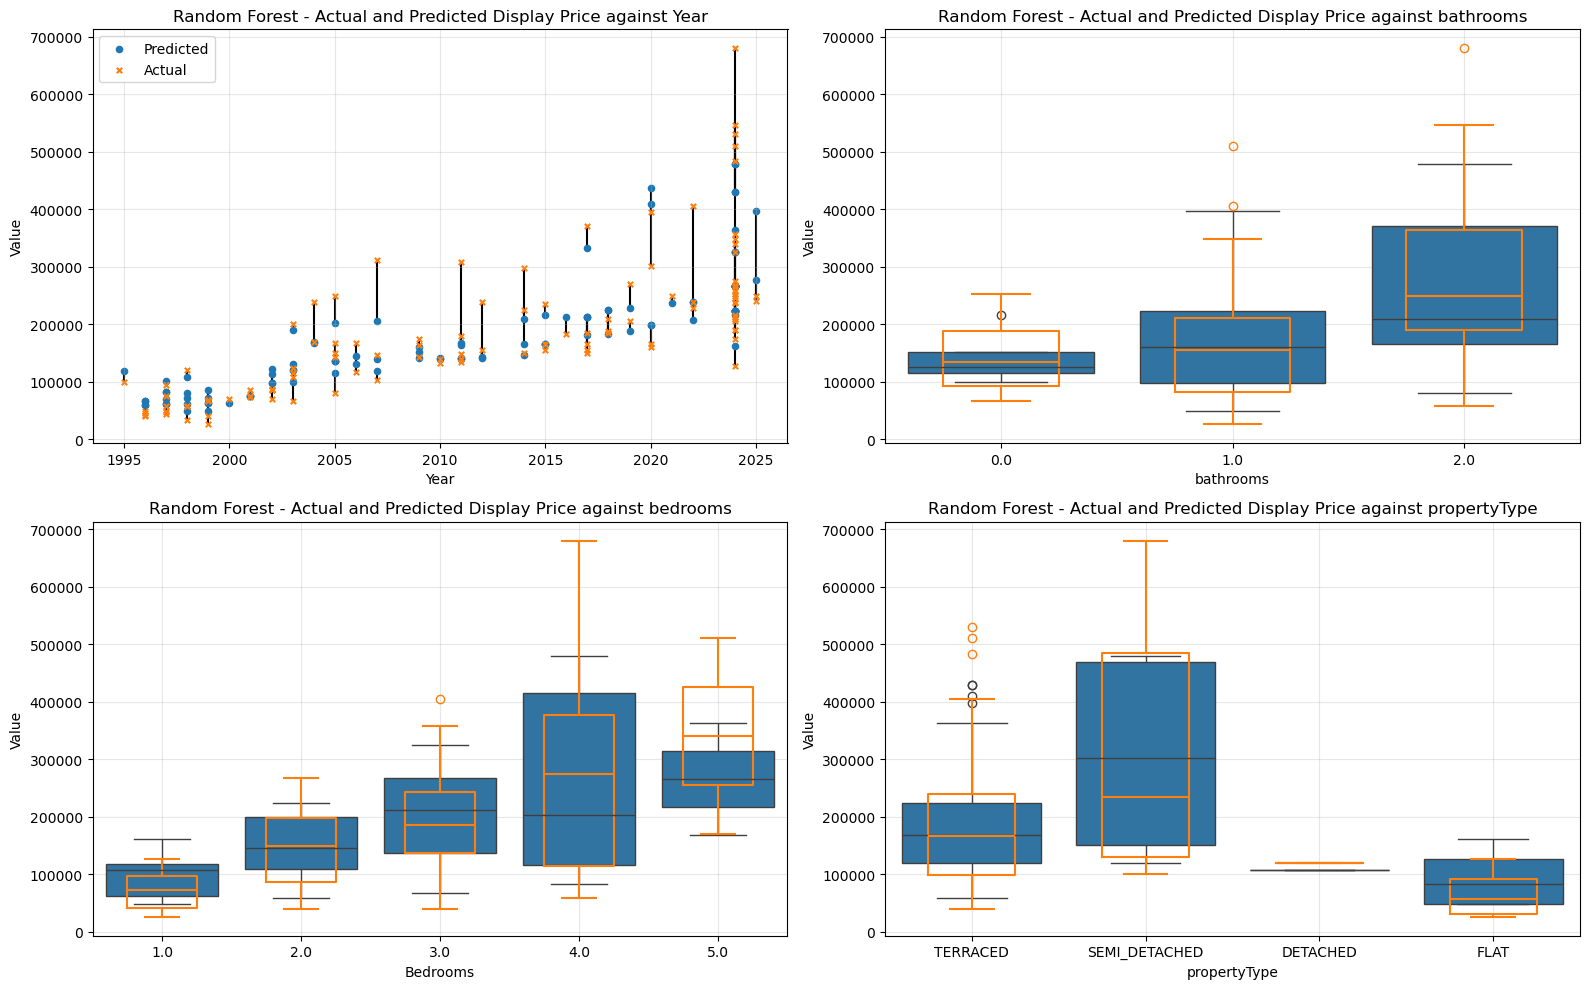

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

temp_df = X_test.copy()
temp_df['pred'] = y_pred_rf
temp_df['actual'] = y_test

# Subplot 1: Actual and Predicted against Year
ax = axes[0,0]
xx = np.vstack([X_test['year_sold'],X_test['year_sold']])
yy = np.vstack([y_pred_rf,y_test])
ax.plot(xx,yy, '-ok', mfc='C1', mec='C1',marker=None, zorder=1)
ax.scatter(X_test['year_sold'], y_pred_rf, s=20, label="Predicted")
ax.scatter(X_test['year_sold'], y_test, s=15, marker='x', label="Actual")
ax.set_title("Random Forest - Actual and Predicted Display Price against Year")
ax.set_xlabel("Year")
ax.set_ylabel("Value")
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Subplot 2: Actual and Predicted against Year
ax = axes[1,0]
pred_prop_strip = sns.boxplot(ax=ax, x=temp_df['bedrooms'], y=temp_df['pred'])
actu_prop_strip = sns.boxplot(ax=ax, x=temp_df['bedrooms'], y=temp_df['actual'], width=0.5, fill=False)
ax.set_title("Random Forest - Actual and Predicted Display Price against bedrooms")
ax.set_xlabel("Bedrooms")
ax.set_ylabel("Value")
ax.grid(alpha=0.3)

# Subplot 3: Actual and Predicted against Year
ax = axes[0,1]
pred_prop_strip = sns.boxplot(ax=ax, x=temp_df['bathrooms'], y=temp_df['pred'])
actu_prop_strip = sns.boxplot(ax=ax, x=temp_df['bathrooms'], y=temp_df['actual'], width=0.5, fill=False)
ax.set_title("Random Forest - Actual and Predicted Display Price against bathrooms")
ax.set_xlabel("bathrooms")
ax.set_ylabel("Value")
ax.grid(alpha=0.3)

# Subplot 4: Actual and Predicted against propertyType
ax = axes[1,1]
pred_prop_strip = sns.boxplot(ax=ax, x=propType_label_encoder.inverse_transform(temp_df['propertyType']), y=temp_df['pred'])
actu_prop_strip = sns.boxplot(ax=ax, x=propType_label_encoder.inverse_transform(temp_df['propertyType']), y=temp_df['actual'], width=0.5, fill=False)
ax.set_title("Random Forest - Actual and Predicted Display Price against propertyType")
ax.set_xlabel("propertyType")
ax.set_ylabel("Value")
ax.grid(alpha=0.3)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## 2.3 Gradient Boosting

In [51]:
param_grid = {
        'min_child_weight': [1, 2, 5, 10],
        'gamma': [0.25, 0.5, 1, 1.5, 2, 5],
        'subsample': [0.4, 0.6, 0.8, 1.0],
        'learning_rate': [0.01, 0.1, 1.],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 7, 10],
        }

# Train an XGBoost regressor
xgb_model = XGBRegressor(random_state=42)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

xgb_model = XGBRegressor(**best_params, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred_xgb)
print("R Squared:", r2)
mse = mean_squared_error(y_test, y_pred_xgb)
print("Mean Squared Error:", mse)

Fitting 3 folds for each of 4320 candidates, totalling 12960 fits
Best parameters found:  {'colsample_bytree': 0.8, 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.6}
R Squared: 0.822884981813844
Mean Squared Error: 2454534901.725589


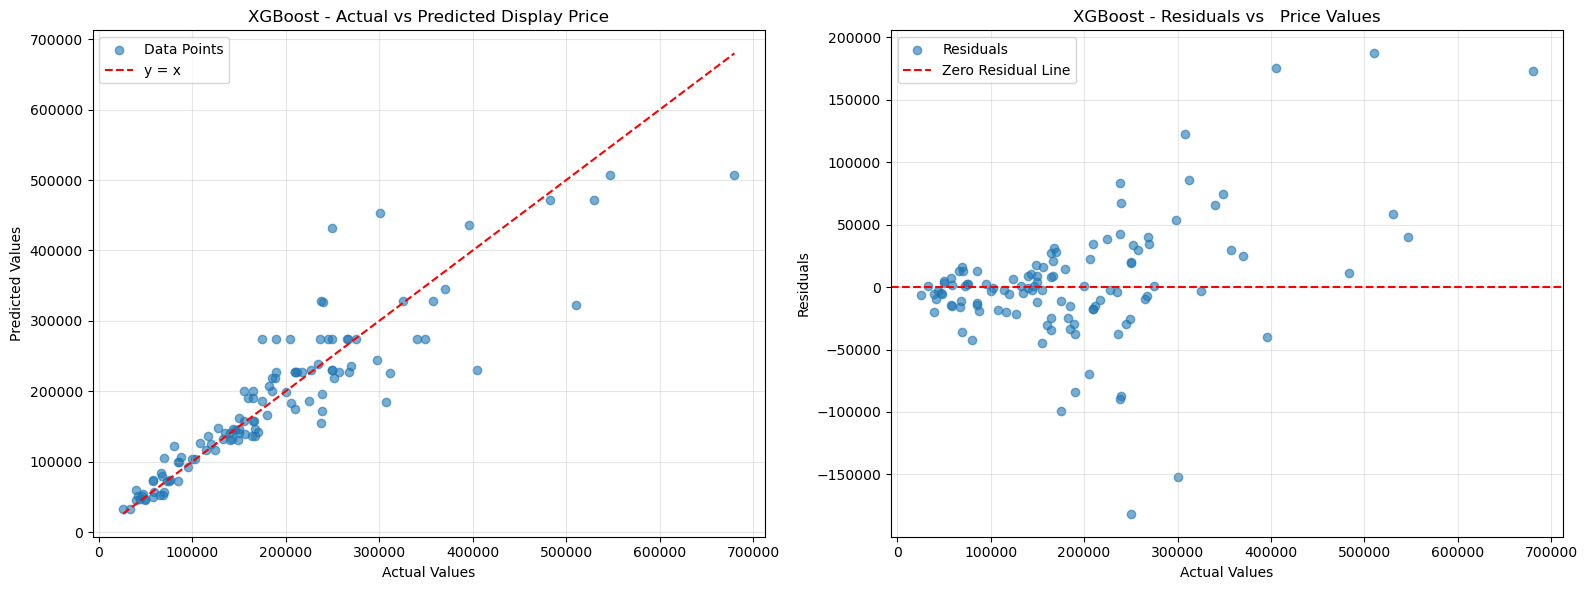

In [52]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Subplot 1: Actual vs Predicted Values
ax = axes[0]
ax.scatter(y_test, y_pred_xgb, alpha=0.6, label="Data Points")
ax.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()],color='red',linestyle='--',label="y = x") 
ax.set_title("XGBoost - Actual vs Predicted Display Price")
ax.set_xlabel("Actual Values")
ax.set_ylabel("Predicted Values")
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Subplot 2: Residuals vs Actual Values
ax = axes[1]
residuals = y_test - y_pred_xgb
ax.scatter(y_test, residuals, alpha=0.6, label="Residuals")
ax.axhline(0, color='red', linestyle='--', label="Zero Residual Line") 
ax.set_title("XGBoost - Residuals vs   Price Values")
ax.set_xlabel("Actual Values")
ax.set_ylabel("Residuals")
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

C:\Users\roryj\AppData\Local\Temp\ipykernel_31064\3486881528.py:11: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "-ok" (-> marker='o'). The keyword argument will take precedence.



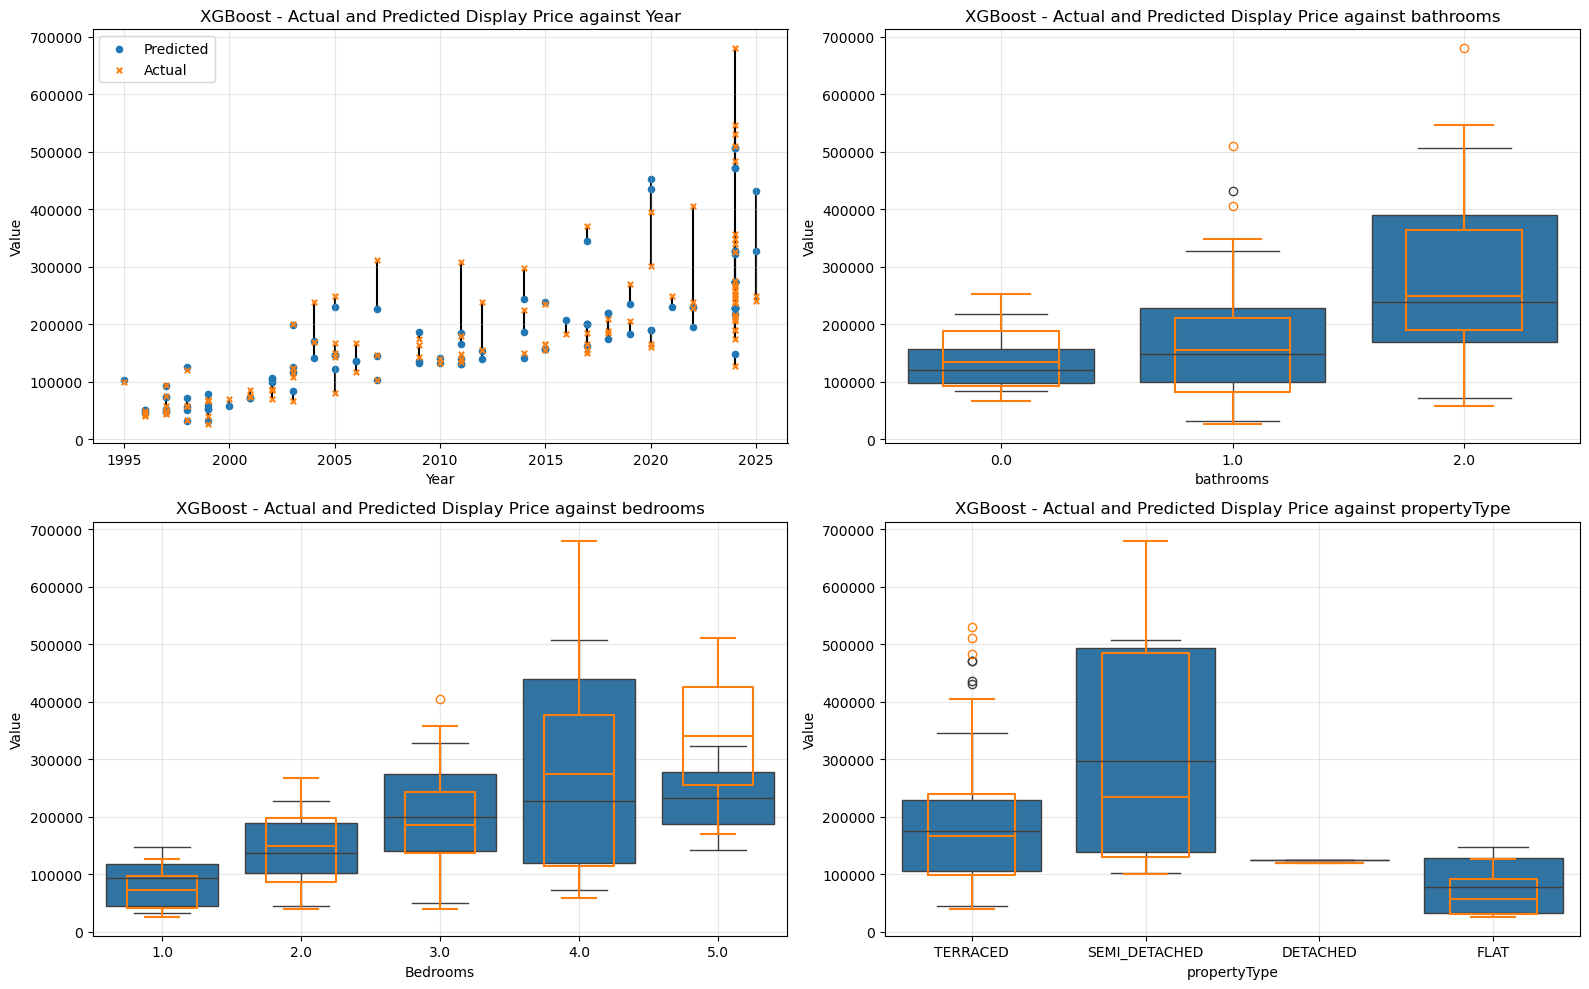

In [54]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

temp_df = X_test.copy()
temp_df['pred'] = y_pred_xgb
temp_df['actual'] = y_test

# Subplot 1: Actual and Predicted against Year
ax = axes[0,0]
xx = np.vstack([X_test['year_sold'],X_test['year_sold']])
yy = np.vstack([y_pred_xgb,y_test])
ax.plot(xx,yy, '-ok', mfc='C1', mec='C1',marker=None, zorder=1)
ax.scatter(X_test['year_sold'], y_pred_xgb, s=20, label="Predicted")
ax.scatter(X_test['year_sold'], y_test, s=15, marker='x', label="Actual")
ax.set_title("XGBoost - Actual and Predicted Display Price against Year")
ax.set_xlabel("Year")
ax.set_ylabel("Value")
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Subplot 2: Actual and Predicted against Year
ax = axes[1,0]
pred_prop_strip = sns.boxplot(ax=ax, x=temp_df['bedrooms'], y=temp_df['pred'])
actu_prop_strip = sns.boxplot(ax=ax, x=temp_df['bedrooms'], y=temp_df['actual'], width=0.5, fill=False)
ax.set_title("XGBoost - Actual and Predicted Display Price against bedrooms")
ax.set_xlabel("Bedrooms")
ax.set_ylabel("Value")
ax.grid(alpha=0.3)

# Subplot 3: Actual and Predicted against Year
ax = axes[0,1]
pred_prop_strip = sns.boxplot(ax=ax, x=temp_df['bathrooms'], y=temp_df['pred'])
actu_prop_strip = sns.boxplot(ax=ax, x=temp_df['bathrooms'], y=temp_df['actual'], width=0.5, fill=False)
ax.set_title("XGBoost - Actual and Predicted Display Price against bathrooms")
ax.set_xlabel("bathrooms")
ax.set_ylabel("Value")
ax.grid(alpha=0.3)

# Subplot 4: Actual and Predicted against propertyType
ax = axes[1,1]
pred_prop_strip = sns.boxplot(ax=ax, x=propType_label_encoder.inverse_transform(temp_df['propertyType']), y=temp_df['pred'])
actu_prop_strip = sns.boxplot(ax=ax, x=propType_label_encoder.inverse_transform(temp_df['propertyType']), y=temp_df['actual'], width=0.5, fill=False)
ax.set_title("XGBoost - Actual and Predicted Display Price against propertyType")
ax.set_xlabel("propertyType")
ax.set_ylabel("Value")
ax.grid(alpha=0.3)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## 2.4 ARIMA and Holt Smoothing

In [105]:
# Aggregate display_price by year_sold
time_series_data = encoded_df.groupby('year_sold')['display_price'].mean()
# Split the time series data into training and testing sets
train_size = int(len(time_series_data) * train_frac)  # 80% training, 20% testing
train_data = time_series_data[:train_size]
test_data = time_series_data[train_size:]

# Holt
hw_model = ExponentialSmoothing(train_data, trend='add', seasonal=None)
hw_model_fit = hw_model.fit()
hw_simulations = hw_model_fit.simulate(len(test_data),repetitions=10, error="mul")
hw_forecast = hw_model_fit.forecast(steps=len(test_data))
hw_mse = mean_squared_error(test_data, hw_forecast)
hw_r2 = r2_score(test_data, hw_forecast)

# Arima
arima_model = ARIMA(train_data, order=(1, 1, 1))
arima_model_fit = arima_model.fit()
arima_fit_forecast = arima_model_fit.get_forecast(steps=len(test_data))
arima_simulations = arima_model_fit.simulate(len(test_data),repetitions=10, error="mul")
arima_forecast = arima_model_fit.forecast(steps=len(test_data))
arima_mse = mean_squared_error(test_data, arima_forecast)
arima_r2 = r2_score(test_data, arima_forecast)
                 
# Print the scores
print(f"Holt-Winters MSE: {hw_mse:.2f}, R²: {hw_r2:.2f}")
print(f"ARIMA MSE: {arima_mse:.2f}, R²: {arima_r2:.2f}")

Holt-Winters MSE: 1765244023.74, R²: 0.12
ARIMA MSE: 1752402005.73, R²: 0.12


c:\Users\roryj\Anaconda3\envs\DataSci\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

c:\Users\roryj\Anaconda3\envs\DataSci\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

c:\Users\roryj\Anaconda3\envs\DataSci\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\roryj\Anaconda3\envs\DataSci\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

c:\Users\roryj\Anaconda3\envs\DataSci\Lib\site-packages\statsmodels\tsa\base\tsa_model.p

c:\Users\roryj\Anaconda3\envs\DataSci\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\roryj\Anaconda3\envs\DataSci\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\roryj\Anaconda3\envs\DataSci\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

c:\Users\roryj\Anaconda3\envs\DataSci\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\roryj\Anaconda3\envs\DataSci\Lib\site-packages\statsmodels\tsa\statespace\re

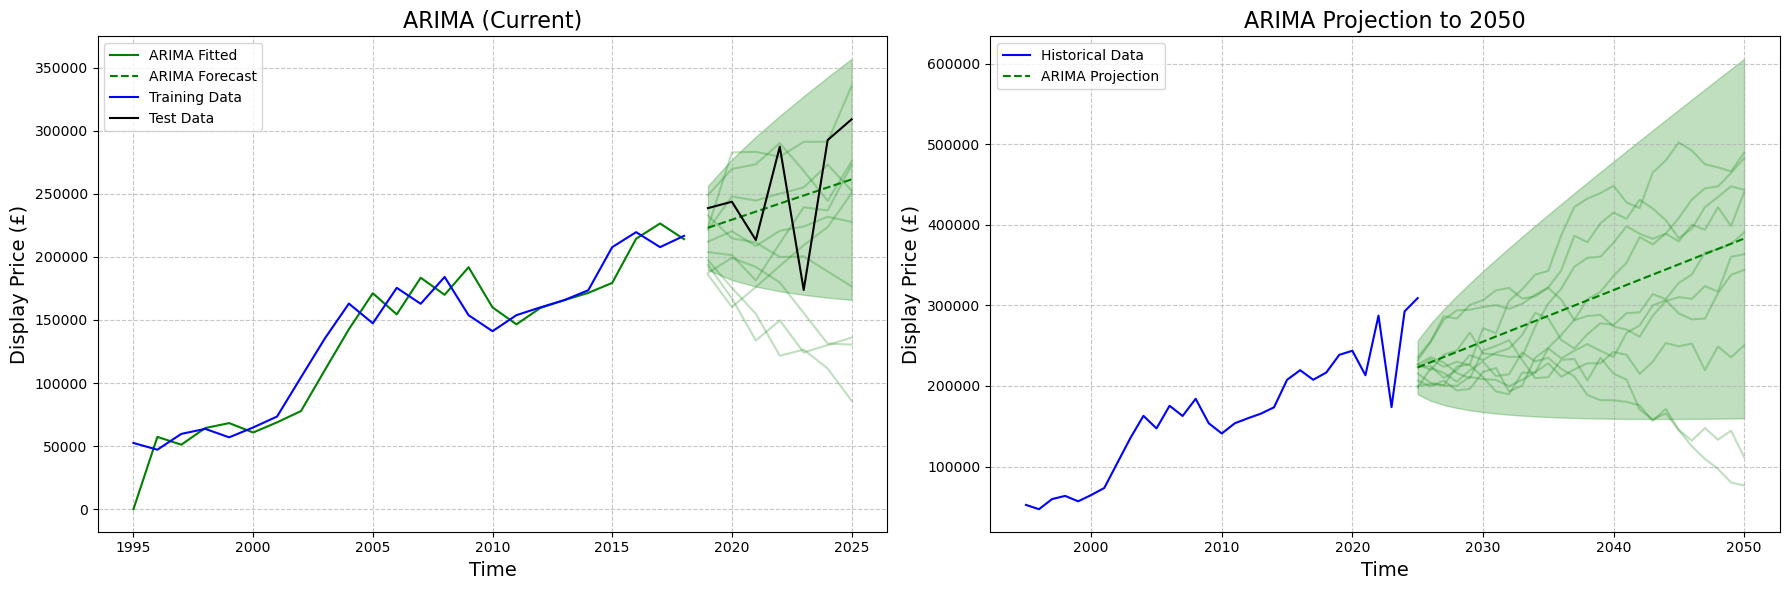

In [107]:
# Extend the forecast to year_max
projection_steps = year_max - 2025 + 1  # Number of years to project from 2025 to year_max
projection_x = np.arange(2025, year_max+1)
# Forecast using Holt-Winters for projection
hw_projection = hw_model_fit.forecast(steps=projection_steps)

# Forecast using ARIMA for projection
arima_fit_projection = arima_model_fit.get_forecast(steps=projection_steps)
arima_projection = arima_model_fit.forecast(steps=projection_steps)

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Left Subplot: Current plot (training, test, fitted, and forecast)
ax = axes[0]
#ax.plot(train_data.index, hw_model_fit.fittedvalues, label='Holt-Winters Fitted', color='orange', linestyle='-')  # Holt Winters projection is poorly constrained (see simulations)
ax.plot(train_data.index, arima_model_fit.fittedvalues, label='ARIMA Fitted', color='green', linestyle='-')
#ax.plot(test_data.index, hw_forecast, label='Holt-Winters Forecast', color='orange', linestyle='--')
ax.plot(test_data.index, arima_forecast, label='ARIMA Forecast', color='green', linestyle='--')
#ax.plot(test_data.index, hw_simulations, alpha=0.15, color="orange", linestyle='-')
ax.plot(test_data.index, train_data.iloc[-1] + arima_simulations, alpha=0.25, color="green", linestyle='-')
ax.fill_between(test_data.index, arima_fit_forecast.conf_int().iloc[:, 0], arima_fit_forecast.conf_int().iloc[:, 1], color='green',alpha=0.25)
ax.plot(train_data, label='Training Data', color='blue')
ax.plot(test_data, label='Test Data', color='black')
ax.set_title("ARIMA (Current)", fontsize=16)
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Display Price (£)", fontsize=14)
ax.legend(fontsize=10)
ax.grid(linestyle='--', alpha=0.7)

arima_simulations = arima_model_fit.simulate(len(projection_x),repetitions=10, error="mul")

# Right Subplot: Projection to year_max
ax = axes[1]
ax.plot(time_series_data, label='Historical Data', color='blue')
#ax.plot(projection_x, hw_projection, label='Holt-Winters Projection', color='orange', linestyle='--')
ax.plot(projection_x, arima_projection, label='ARIMA Projection', color='green', linestyle='--')
ax.plot(projection_x, train_data.iloc[-1] + arima_simulations, alpha=0.25, color="green", linestyle='-')
ax.fill_between(projection_x, arima_fit_projection.conf_int().iloc[:, 0], arima_fit_projection.conf_int().iloc[:, 1], color='green',alpha=0.25)
ax.set_title(f"ARIMA Projection to {year_max}", fontsize=16)
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Display Price (£)", fontsize=14)
ax.legend(fontsize=10)
ax.grid(linestyle='--', alpha=0.7)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


## 2.5 Neural Network

In [32]:
# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)  # Reshape to match output
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Define the neural network
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
model = NeuralNetwork(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 50
batch_size = 32
train_size = X_train_tensor.size(0)

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(train_size)  # Shuffle the data
    epoch_loss = 0

    for i in range(0, train_size, batch_size):
        indices = permutation[i:i + batch_size]
        batch_X, batch_y = X_train_tensor[indices], y_train_tensor[indices]

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / (train_size // batch_size):.4f}")

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_nn = model(X_test_tensor).numpy()

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred_nn)
print("Mean Squared Error:", mse)

Epoch 1/50, Loss: 56920927085.7143
Epoch 2/50, Loss: 56394575140.5714
Epoch 3/50, Loss: 57943778450.2857
Epoch 4/50, Loss: 57801801728.0000
Epoch 5/50, Loss: 57381508534.8571
Epoch 6/50, Loss: 56956650934.8571
Epoch 7/50, Loss: 55688195949.7143
Epoch 8/50, Loss: 56588685604.5714
Epoch 9/50, Loss: 57498964845.7143
Epoch 10/50, Loss: 56745842102.8571
Epoch 11/50, Loss: 56612902034.2857
Epoch 12/50, Loss: 57858875099.4286
Epoch 13/50, Loss: 57554817316.5714
Epoch 14/50, Loss: 55781731913.1429
Epoch 15/50, Loss: 57480690834.2857
Epoch 16/50, Loss: 55940223853.7143
Epoch 17/50, Loss: 56534970368.0000
Epoch 18/50, Loss: 56433463003.4286
Epoch 19/50, Loss: 57436064329.1429
Epoch 20/50, Loss: 56684917467.4286
Epoch 21/50, Loss: 58215676489.1429
Epoch 22/50, Loss: 57784702683.4286
Epoch 23/50, Loss: 58034380068.5714
Epoch 24/50, Loss: 57038328832.0000
Epoch 25/50, Loss: 57180489728.0000
Epoch 26/50, Loss: 54992831634.2857
Epoch 27/50, Loss: 56521094436.5714
Epoch 28/50, Loss: 56392760466.2857
E